## Deps

In [22]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML

import timeit
import itertools


from xgboost import plot_importance

import sys

sys.path.append("../")

from src.event_processing import leer_excel
from src.event_processing import (
    separar_partido_del_equipo_en_lineups,
    separar_partido_en_equipo_pov,
    separar_partidos,
)
from src.match_data_extraction import get_jugadores, get_lineup_duration
from src.utils_CMTC import psl_estimator, build_Q, build_R
from src.utils_CMTC import get_ratio_gains, get_ratio_loss, get_ratio_shots

from src.futbol_types import TransitionMatrix
from src.match_data_extraction import get_lineup_duration
from typing import List
from sklearn.base import RegressorMixin
from src.futbol_types import TransitionMatrix

## Dataset

In [2]:
ds = pd.read_csv("dataset.csv")

ds = ds[ds["target"] != 0]

ds["date"] = pd.to_datetime(ds["date"])
dates = ds["date"]
date_2_3 = dates.mean() + 2 / 3 * dates.std()
date_2_3, dates.max(), dates.min(), dates.mean(), dates.std()

(Timestamp('2013-02-24 14:21:30.714119313'),
 Timestamp('2013-05-19 00:00:00'),
 Timestamp('2012-08-18 00:00:00'),
 Timestamp('2013-01-02 12:07:47.759788544'),
 Timedelta('79 days 15:20:34.431496154'))

<Axes: >

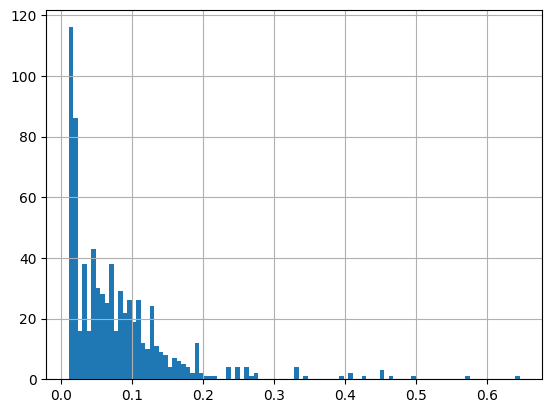

In [3]:
# For a sample player_1 in ds, plot target distribution
players_ocurrences = ds["player_1"].value_counts().sort_values(ascending=False)
sample_player = players_ocurrences.index[0]

sample_player_ds = ds[ds["player_1"] == sample_player]
sample_player_ds["target"].hist(bins=100)

(82550, 33448, 0.7116502008655322, 0.28834979913446784)

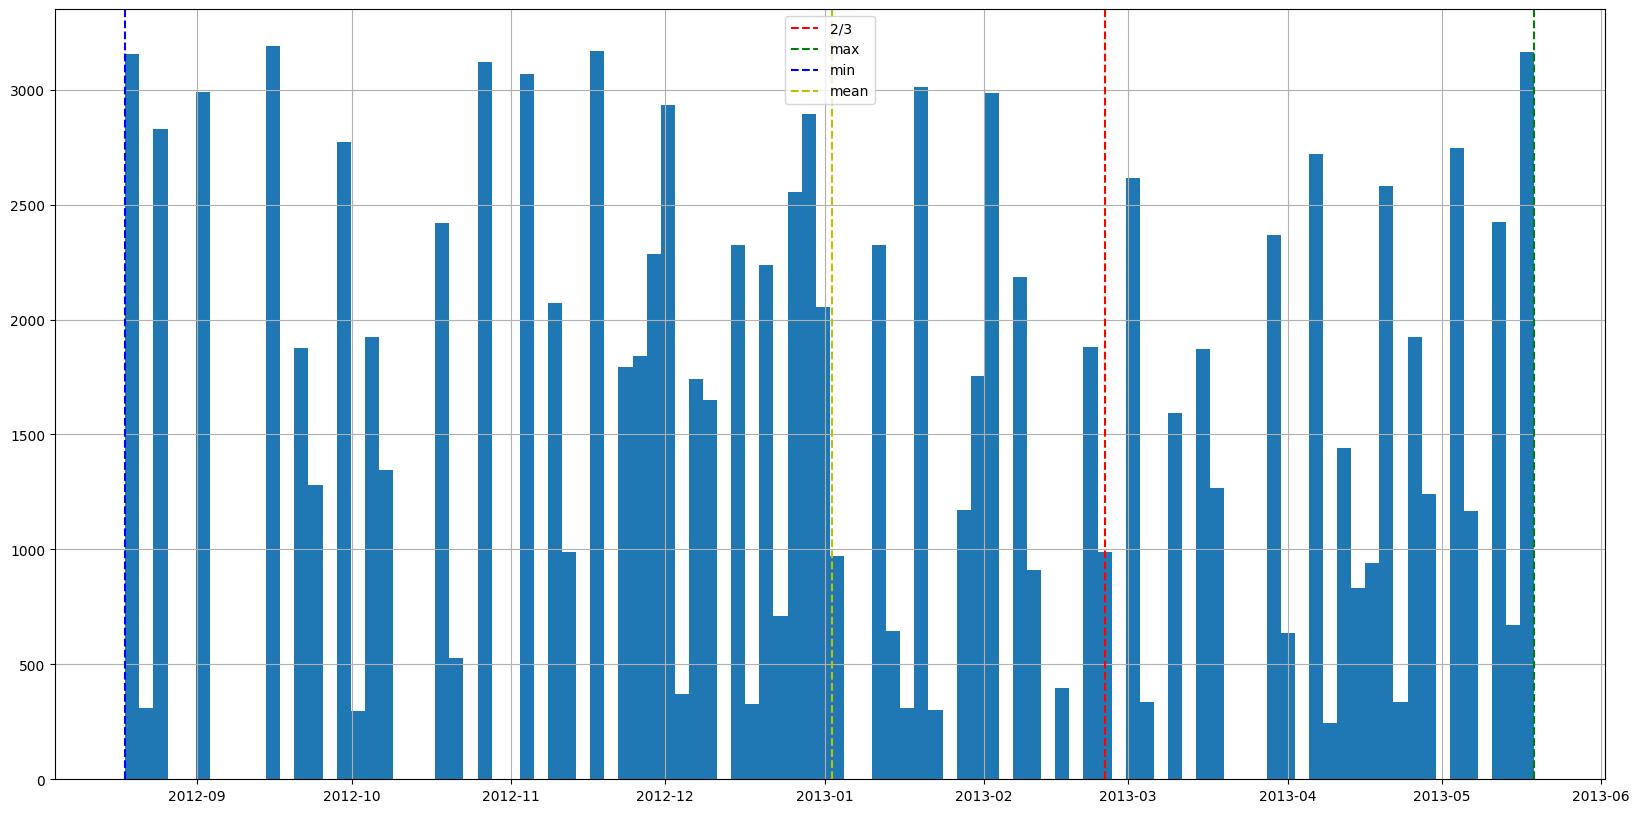

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
dates.hist(bins=100, ax=ax)

# Plot lines for date_2_3, dates.max(), dates.min(), dates.mean()
ax.axvline(date_2_3, color="r", linestyle="--", label="2/3")
ax.axvline(dates.max(), color="g", linestyle="--", label="max")
ax.axvline(dates.min(), color="b", linestyle="--", label="min")
ax.axvline(dates.mean(), color="y", linestyle="--", label="mean")

ax.legend()

left_c = ds[ds["date"] < date_2_3].shape[0]
right_c = ds[ds["date"] >= date_2_3].shape[0]

left_c, right_c, left_c / (right_c + left_c), right_c / (right_c + left_c)

### Train-Test Split

In [26]:
# Select pairs of player_1 and player_2 that appear in the dataset
# Keep them in a test set

pairs = ds[["player_1", "player_2"]].drop_duplicates()
sample_pairs = pairs.sample(100)

test = ds[
    ds["player_1"].isin(sample_pairs["player_1"])
    & ds["player_2"].isin(sample_pairs["player_2"])
]
train = ds[
    ~ds["player_1"].isin(sample_pairs["player_1"])
    | ~ds["player_2"].isin(sample_pairs["player_2"])
    | ~ds["player_1"].isin(sample_pairs["player_2"])
    | ~ds["player_2"].isin(sample_pairs["player_1"])
]

train_left = train[train["date"] < date_2_3]
test_right = test[test["date"] >= date_2_3]

## Basic XGB Reg

In [44]:
xgb_model = xgb.XGBRegressor()

X_train = train_left.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_train = train_left["target"]

X_test = test_right.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_test = test_right["target"]

xgb_model.fit(X_train, y_train)

sc = xgb_model.score(X_test, y_test)

mse = mean_squared_error(y_test, xgb_model.predict(X_test))

sc, mse

(-0.1629834634495786, np.float64(0.006091009603520992))

(0.0, 1.0)

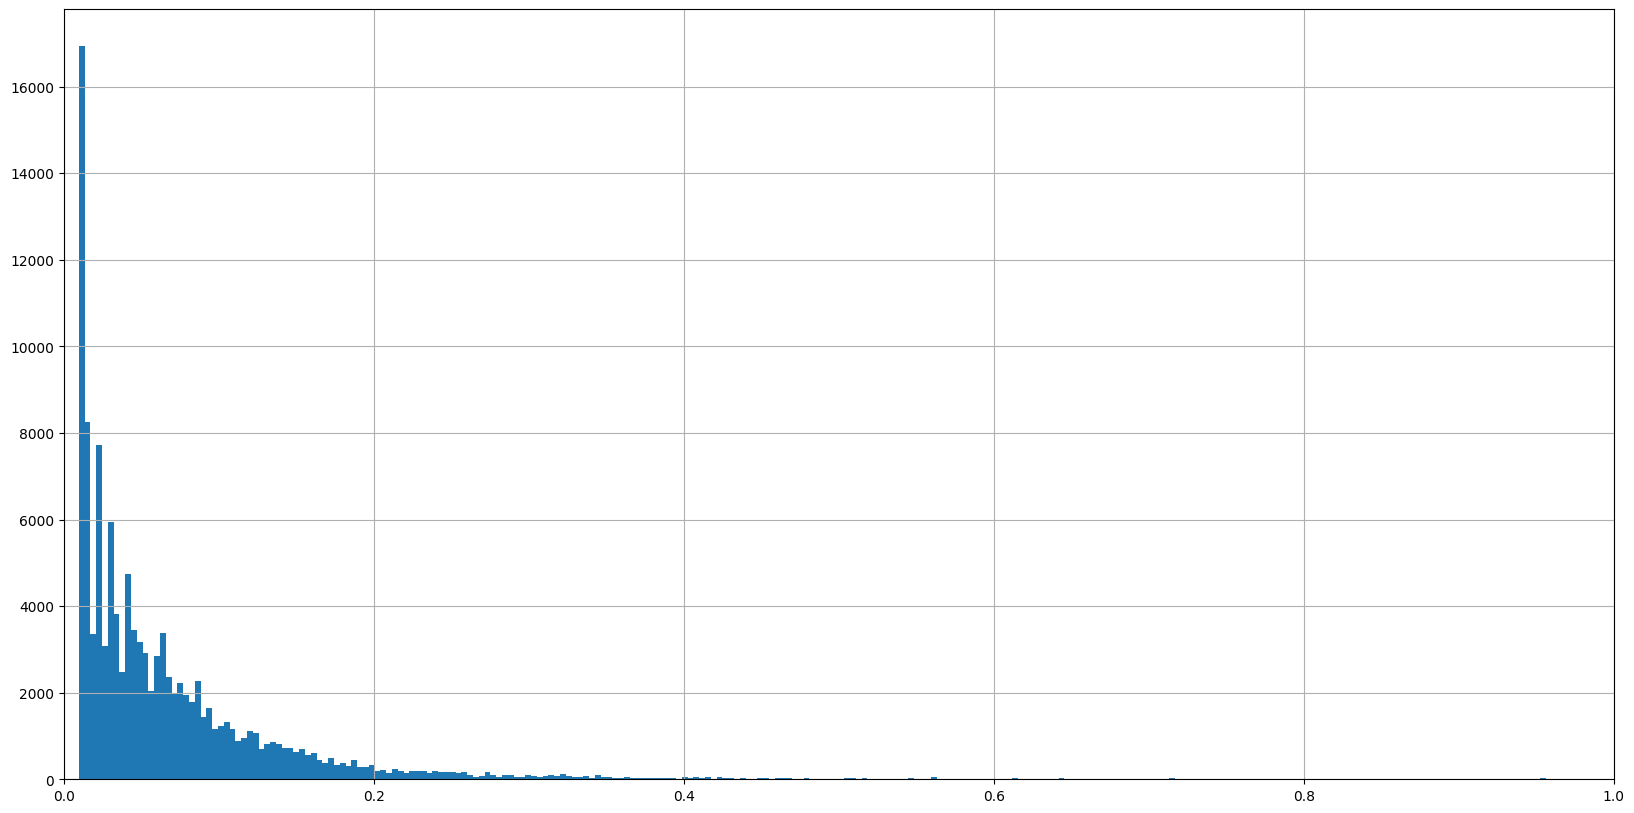

In [45]:
fig, ax = plt.subplots(figsize=(20, 10))

ds["target"].hist(bins=1000, ax=ax)

ax.set_xlim(0, 1)

In [46]:
# Variance, mean, std, min, max for target

ds["target"].var(), ds["target"].mean(), ds["target"].std(), ds["target"].min(), ds["target"].max()

(np.float64(0.008503244578030554),
 np.float64(0.07147860218704535),
 np.float64(0.09221303908900604),
 np.float64(0.009765625),
 np.float64(3.750000000000013))

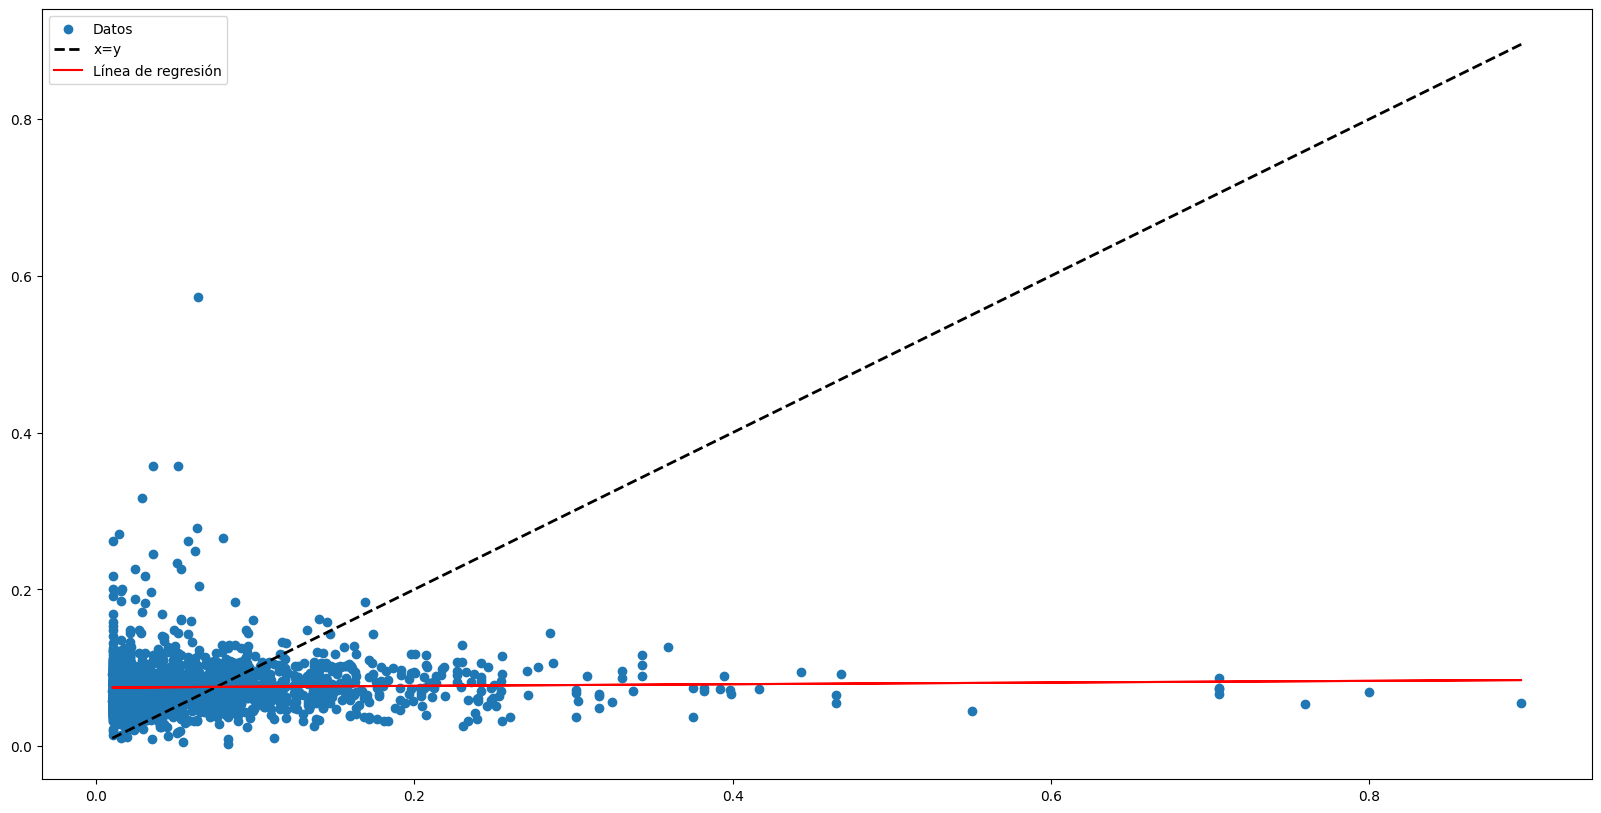

In [21]:
# Datos de prueba y predicciones
y_test = np.array(y_test)
y_pred = xgb_model.predict(X_test)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Dibujar el gráfico de dispersión
ax.scatter(y_test, y_pred, label="Datos")

# Dibujar la línea x=y
ax.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, label="x=y"
)

# Calcular la línea de regresión
reg = LinearRegression().fit(y_test.reshape(-1, 1), y_pred)
y_pred_line = reg.predict(y_test.reshape(-1, 1))

# Dibujar la línea de regresión
ax.plot(y_test, y_pred_line, color="red", label="Línea de regresión")

# Añadir leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


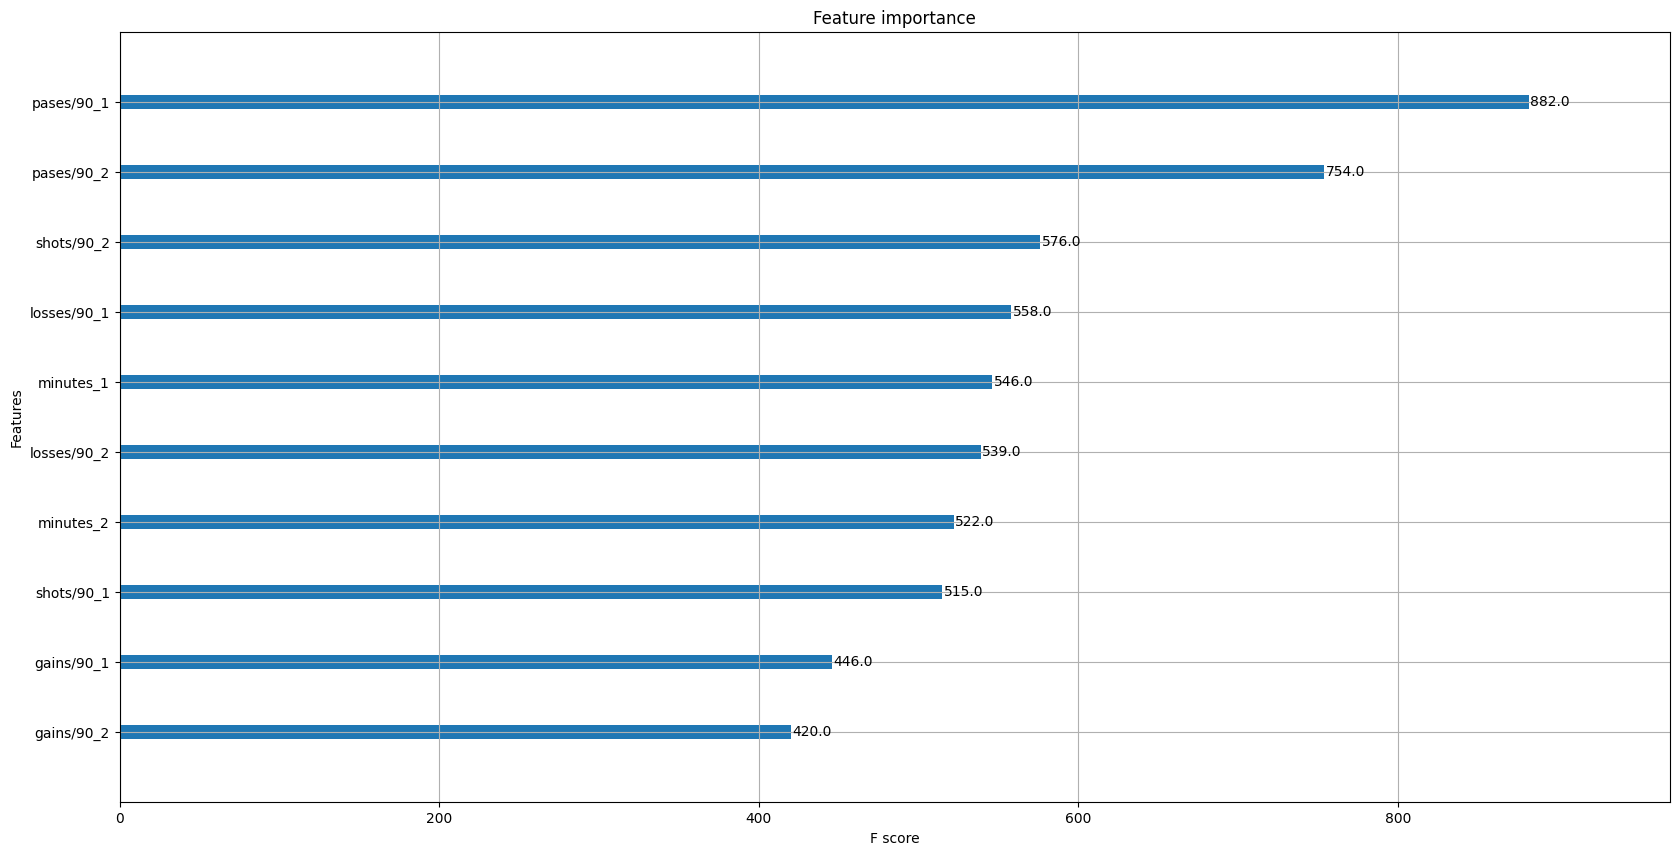

In [22]:
# Feature importance


fig, ax = plt.subplots(figsize=(20, 10))

plot_importance(xgb_model, ax=ax)

plt.show()

## Player Custom Features

In [18]:
epl = leer_excel("../SampleData/epl.xlsx")

In [66]:
partidos = separar_partidos(epl)
partidos = [partido for partido in partidos if partido["date"].values[0] > date_2_3]

sample_partido = partidos[np.random.randint(len(partidos))]

equipos = separar_partido_en_equipo_pov(sample_partido)
sample_equipo = equipos[np.random.randint(2)]
lineups = separar_partido_del_equipo_en_lineups(sample_equipo)
sample_lineup = lineups[np.random.randint(2)]
jugadores = get_jugadores(sample_lineup)

jugador = jugadores[np.random.randint(len(jugadores))]
lineups = separar_partido_del_equipo_en_lineups(sample_equipo)
psls_diffs = np.array([psl_estimator(build_Q(build_R(lineup))) for lineup in lineups])
lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

In [68]:
def get_features(player_1, partido):
    # For a given player, get aggregated features for all matches played before partido
    # home_team_id if player_1 is in home team, away_team_id if player_1 is in away team
    team_id = partido[partido["player_id"] == player_1]["team_id"].values[0]

    player_data = {
        "pases/90": 0,
        "shots/90": 0,
        "losses/90": 0,
        "gains/90": 0,
        "minutes": 0,
    }

    # Get all matches played
    date = partido["date"].values[0]
    prev_matches = epl[epl["date"] < date]
    for partido in separar_partidos(prev_matches):
        for equipo in separar_partido_en_equipo_pov(partido):
            if equipo["team_id"].values[0] == team_id:
                if player_1 in get_jugadores(equipo):
                    for lineup in separar_partido_del_equipo_en_lineups(equipo):
                        players = get_jugadores(lineup)
                        if player_1 in players:
                            minutes = get_lineup_duration(lineup)
                            if minutes == 0:
                                continue

                            player_data["shots/90"] += get_ratio_shots(lineup, player_1)
                            player_data["losses/90"] += get_ratio_loss(lineup, player_1)
                            player_data["gains/90"] += get_ratio_gains(lineup, player_1)

                            player_data["minutes"] += minutes

                            passes = lineup[
                                (lineup["player_id"] == player_1)
                                & (lineup["type"] == 1)
                                & (lineup["outcome"] == 1)
                            ]

                            player_data["pases/90"] += passes.shape[0] / minutes

    return player_data

In [84]:
X_test.shape

(1943, 10)

In [130]:
def predicted_psl(p1: int, lineups: List[List[int]], model: RegressorMixin) -> TransitionMatrix:
    # Given Q and p1, update value for passes from p1 to every other player, and from every other player to p1
    counter = 0
    psls = []
    for lineup in lineups:
        jugadores = get_jugadores(lineup)
        R = build_R(lineup)
        for i, player in enumerate(jugadores):
            if player == p1:
                p1_features = pd.DataFrame([get_features(player, lineup)])
                for j, player2 in enumerate(jugadores):
                    if player2 != player:
                        counter += 1
                        p2_features = pd.DataFrame([get_features(player2, lineup)])
                        R[i + 1, j + 1] = model.predict(
                            pd.concat([p1_features, p2_features]).values.reshape(1, -1)
                        )[0]
                        R[j + 1, i + 1] = model.predict(
                            pd.concat([p2_features, p1_features]).values.reshape(1, -1)
                        )[0]

        Q = build_Q(R)
        psls.append(psl_estimator(Q))

    # print(counter)
    lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

    return np.average(psls, weights=lineup_durations)

In [109]:
from src.utils_CMTC import team_psl

psl_ = predicted_psl(jugador, lineups, xgb_model)
psl = team_psl(sample_equipo)

psl, psl_, mean_squared_error([psl], [psl_])

30


(np.float64(0.019619676938909286),
 np.float64(0.01959153180420649),
 np.float64(7.921486074386319e-10))

In [110]:
bad_model = xgb.XGBRegressor(max_depth=1, n_estimators=1)
bad_model.fit(X_train, y_train)

psl_ = predicted_psl(jugador, lineups, bad_model)
psl = team_psl(sample_equipo)

psl, psl_, mean_squared_error([psl], [psl_])

30


(np.float64(0.019619676938909286),
 np.float64(0.01946529511486377),
 np.float64(2.383374759562125e-08))

In [111]:
sample_pairs

,player_1,player_2
5305,39529.0,11212.0
6172,19151.0,26900.0
13335,5750.0,49949.0
274939,76227.0,9110.0
108300,76359.0,13017.0
...,...,...
18180,40799.0,38429.0
191760,18681.0,59940.0
6698,18073.0,8380.0
182245,41823.0,48759.0


In [190]:
date = date_2_3
matches = epl[epl["date"] >= date]
# psls_diffs: List[Tuple[float, float]] = []
model = xgb_model

# Pre-caching jugadores and R for each lineup to avoid recomputation
iterator = tqdm(separar_partidos(matches))
for pi, partido in enumerate(iterator):
    try:
        match_id = partido["match_id"].values[0]
    except:
        pass
    for equipo in separar_partido_en_equipo_pov(partido):
        team_psls = []
        team_alt_psls = []

        lineups = separar_partido_del_equipo_en_lineups(equipo)
        lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

        for li, lineup in enumerate(lineups):
            jugadores = get_jugadores(lineup)
            R = build_R(lineup)

            team_psls.append(psl_estimator(build_Q(R)))

            for i, player in enumerate(jugadores):
                if player in sample_pairs["player_1"].values:
                    p1_features = pd.DataFrame([get_features(player, lineup)])
                    for j, player2 in enumerate(jugadores):
                        if player2 != player:

                            p2_features = pd.DataFrame([get_features(player2, lineup)])

                            q_1_2 = model.predict(
                                pd.concat([p1_features, p2_features]).values.reshape(
                                    1, -1
                                )
                            )[0]

                            q_2_1 = model.predict(
                                pd.concat([p2_features, p1_features]).values.reshape(
                                    1, -1
                                )
                            )[0]

                            R[i + 1, j + 1] = q_1_2
                            R[j + 1, i + 1] = q_2_1

            team_alt_psls.append(psl_estimator(build_Q(R)))
            try:
                iterator.set_postfix(
                    {
                        f"sub_psls": np.average(
                            team_psls, weights=lineup_durations[: li + 1]
                        ),
                        f"sub_alt_psls": np.average(
                            team_alt_psls, weights=lineup_durations[: li + 1]
                        ),
                        f"lineup_count": li + 1,
                        "psl_diff": np.mean(
                            [abs(psl - psl_alt) for psl, psl_alt in psls_diffs]
                        ),
                        "current_psl_diff": f"psl: {psl}, psl_alt: {psl_alt}, diff: {abs(psl - psl_alt)}",
                        f"psls": str(psls_diffs),
                    }
                )
            except:
                print(team_psls)
                print(lineup_durations[: li + 1])
                print(lineup_durations, li)

        psl = np.average(team_psls, weights=lineup_durations)
        psl_alt = np.average(team_alt_psls, weights=lineup_durations)
        psls_diffs.append((psl, psl_alt))

        iterator.set_postfix(
            {
                "psl_diff": np.mean(
                    [abs(psl - psl_alt) for psl, psl_alt in psls_diffs]
                ),
                "current_psl_diff": f"psl: {psl}, psl_alt: {psl_alt}, diff: {abs(psl - psl_alt)}",
                f"psls": str(psls_diffs),
            }
        )


psls_diffs_ = np.array(psls_diffs)

 76%|███████▌  | 84/111 [1:56:29<1:24:32, 187.85s/it, sub_psls=0.0119, sub_alt_psls=0.0111, lineup_count=2, psl_diff=0.00166, current_psl_diff=psl: 0.015211070629024007, psl_alt: 0.017996207580289, diff: 0.0027851369512649944, psls=[(np.float64(0.04044878811695399), np.float64(0.0344586584787615)), (np.float64(0.0222947956239485), np.float64(0.019796164615056275)), (np.float64(0.017318814309279947), np.float64(0.017318814309279947)), (np.float64(0.018974667303509482), np.float64(0.01790010303098091)), (np.float64(0.02922390615638698), np.float64(0.02756447029950026)), (np.float64(0.022701932636816035), np.float64(0.02584750579477674)), (np.float64(0.016573557775754477), np.float64(0.015376608689158456)), (np.float64(0.04063383265249436), np.float64(0.04346191886349149)), (np.float64(0.07447196337520942), np.float64(0.07760764764974985)), (np.float64(0.0016033750425037937), np.float64(0.0016543614043618038)), (np.float64(0.041886066659706525), np.float64(0.041421435431468145)), (np.floa

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [3:23:54<00:00, 110.22s/it, psl_diff=0.00188, current_psl_diff=psl: 0.016875561636353623, psl_alt: 0.017026304188134576, diff: 0.0001507425517809531, psls=[(np.float64(0.04044878811695399), np.float64(0.0344586584787615)), (np.float64(0.0222947956239485), np.float64(0.019796164615056275)), (np.float64(0.017318814309279947), np.float64(0.017318814309279947)), (np.float64(0.018974667303509482), np.float64(0.01790010303098091)), (np.float64(0.02922390615638698), np.float64(0.02756447029950026)), (np.float64(0.022701932636816035), np.float64(0.02584750579477674)), (np.float64(0.016573557775754477), np.float64(0.015376608689158456)), (np.float64(0.04063383265249436), np.float64(0.04346191886349149)), (np.float64(0.07447196337520942), np.float64(0.07760764764974985)), (np.float64(0.0016033750425037937), np.float64(0.0016543614043618038)), (np.float64(0.041886066659706525), np.float64(0.041421435431468145)), (np.float64(0.0071866709117338525), np.float64(0.00727022296

In [191]:
psls_diffs_arr = np.array(psls_diffs)

In [192]:
len(psls_diffs_arr)

220

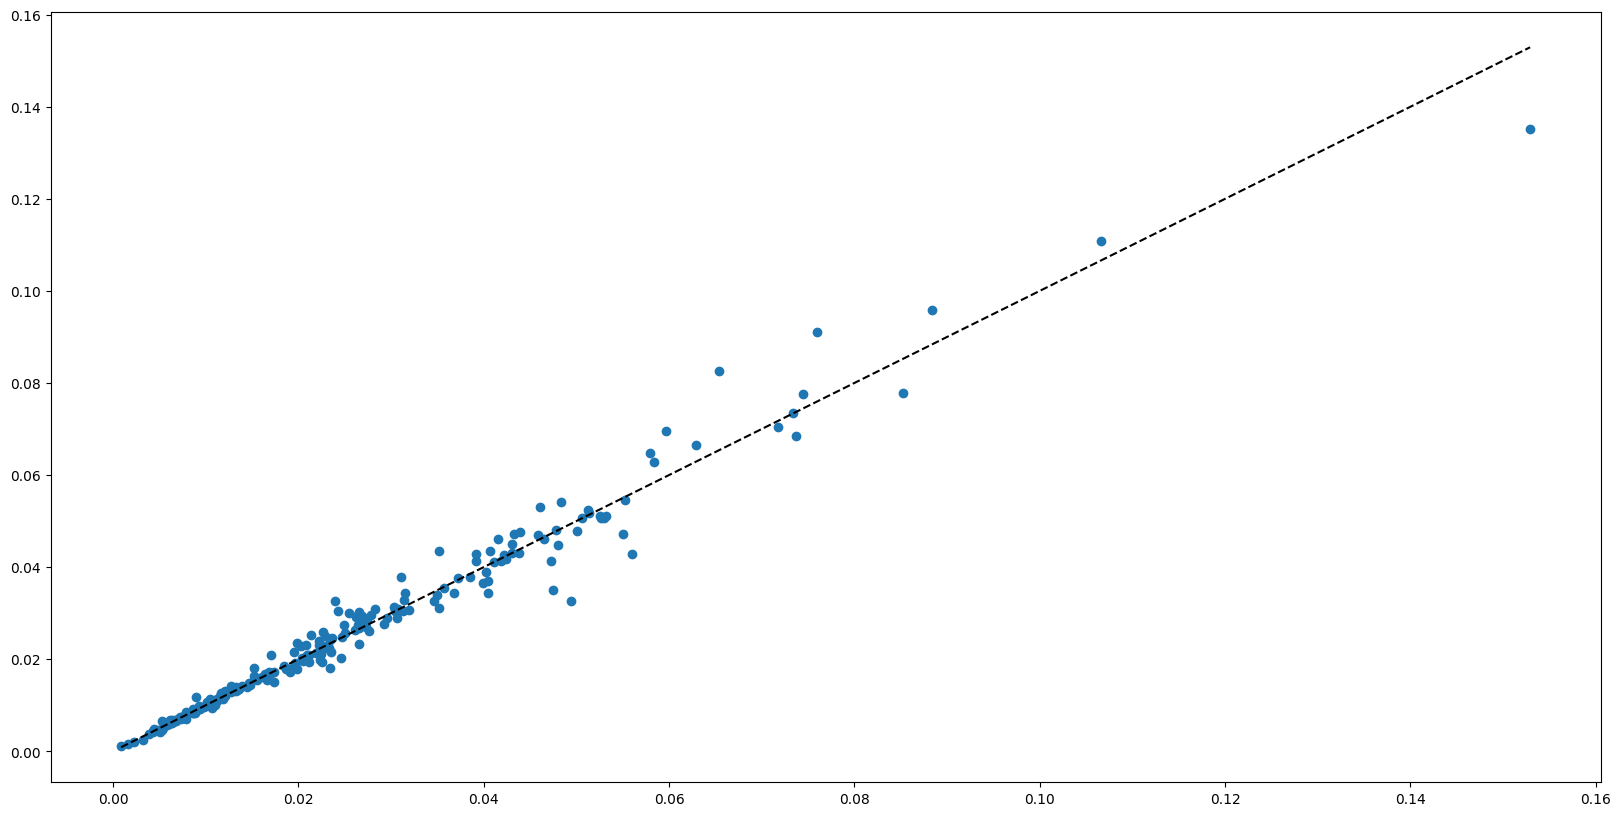

In [193]:
arr = psls_diffs_arr

fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(arr[:, 0], arr[:, 1])

# Plot y=x for the range of the data
ax.plot([arr[:, 0].min(), arr[:, 0].max()], [arr[:, 0].min(), arr[:, 0].max()], "k--")


### Linear Regression

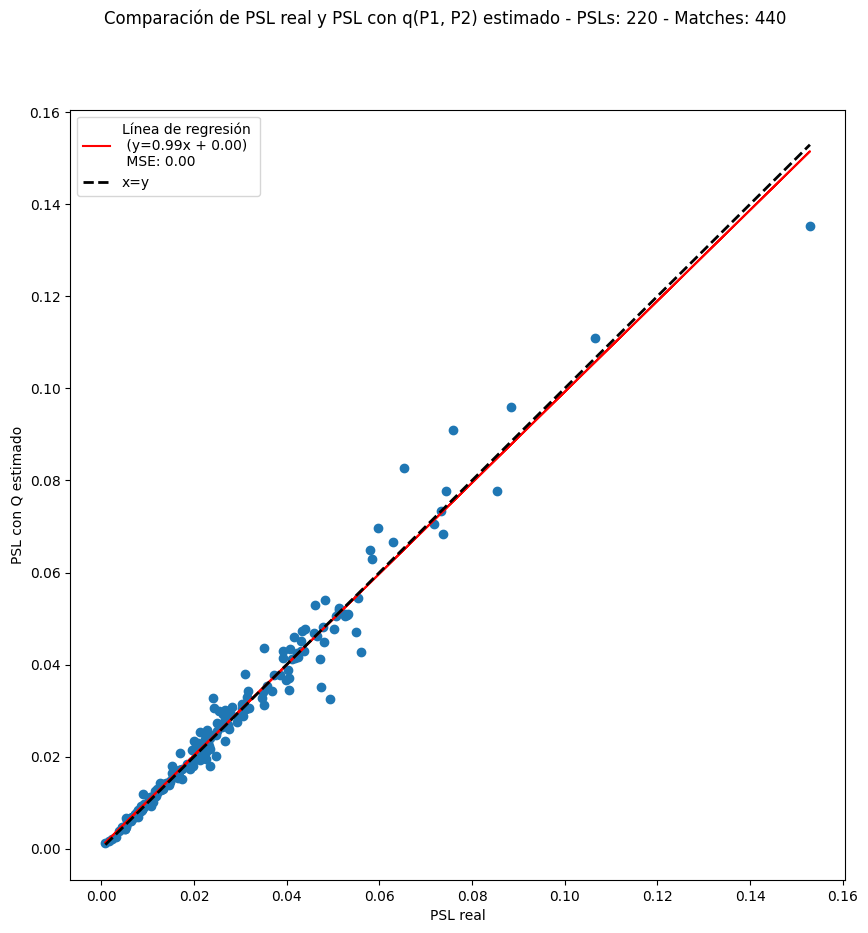

In [194]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Suponiendo que `arr` ya está definido
# Linear regression for the data, compare slope to y=x
reg = LinearRegression().fit(arr[:, 0].reshape(-1, 1), arr[:, 1])
y_pred_line = reg.predict(arr[:, 0].reshape(-1, 1))

# Obtener la pendiente (slope) y la intersección (intercept)
slope = reg.coef_[0]
intercept = reg.intercept_

# Mean squared error
mse = mean_squared_error(arr[:, 0], arr[:, 1])

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(arr[:, 0], y_pred_line, color="red", label=f"Línea de regresión \n (y={slope:.2f}x + {intercept:.2f}) \n MSE: {mse:.2f}")

ax.scatter(arr[:, 0], arr[:, 1])

# Plot y=x for the range of the data
ax.plot([arr[:, 0].min(), arr[:, 0].max()], [arr[:, 0].min(), arr[:, 0].max()], "k--", lw=2, label="x=y")

ax.set_xlabel("PSL real")
ax.set_ylabel("PSL con Q estimado")

fig.suptitle(
    f"Comparación de PSL real y PSL con q(P1, P2) estimado - PSLs: {len(arr)} - Matches: {len(arr) * 2}"
)

plt.legend()

In [196]:
slope, intercept, mse

(np.float64(0.9874685813616221),
 np.float64(0.0004866092369307101),
 np.float64(1.2440044584277338e-05))

In [195]:
# Save psls_diffs_arr
np.save("psls_diffs_arr.npy", psls_diffs_arr)

In [197]:
# Calculate R^2 

from sklearn.metrics import r2_score

r2_score(arr[:, 0], arr[:, 1])

0.9702628077348673

## Precomputing

In [201]:
max_n_lineups = np.max(
    [
        len(separar_partido_del_equipo_en_lineups(equipo))
        for partido in separar_partidos(epl)
        for equipo in separar_partido_en_equipo_pov(partido)
    ]
)
max_n_lineups

np.int64(4)

### Precompute R

In [221]:
n_matches = len(separar_partidos(epl))

R_storage = np.zeros((n_matches, 2, max_n_lineups, 15, 15))

def precompute_R_matrices(matches, R_storage):
    for pi, partido in enumerate(tqdm(separar_partidos(matches))):
        try:
            match_id = partido["match_id"].values[0]
        except:
            continue

        for team_index, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
            lineups = separar_partido_del_equipo_en_lineups(equipo)

            for lineup_index, lineup in enumerate(lineups):
                jugadores = get_jugadores(lineup)

                # Build the R matrix (14x14)
                R = build_R(lineup)

                # Indexes 1 through 11 are players, both columns and rows
                # Store the R matrix in the storage last 14x14 part of the 15x15 matrix,
                # Save the lineup index in the first column from 1 to 11
                # Also in the first row
                if len(jugadores) > 11:
                    continue
                
                jugadores = np.array(jugadores)
                if len(jugadores) < 11:
                    jugadores = np.pad(jugadores, (0, 11 - len(jugadores)))
                R_storage[pi, team_index, lineup_index, 1:, 1:] = R
                R_storage[pi, team_index, lineup_index, 0, 2:13] = jugadores
                R_storage[pi, team_index, lineup_index, 2:13, 0] = jugadores

precompute_R_matrices(epl, R_storage)

100%|██████████| 380/380 [02:58<00:00,  2.13it/s]


In [229]:
# Save R_storage
np.save("R_storage.npy", R_storage)

In [23]:
R_storage = np.load("R_storage.npy")

In [234]:
def visualize_R_matrix(R):
    # 0, 1:12 are player ids,
    # 1:12, 0 are also player ids,
    # 1:, 1: is the true R matrix, :2f precision

    html = "<table>"
    for i in range(15):
        html += "<tr>"
        for j in range(15):
            if i == 0 and j == 0:
                html += "<td></td>"  # Empty top-left cell
            elif i == 0 and j == 1 or i == 1 and j == 0: # Gain state col/row headers
                html += "<td><b>G</b></td>"
            elif i == 0 and j == 13 or i == 13 and j == 0: # Loss state col/row headers
                html += "<td><b>L</b></td>"
            elif i == 0 and j == 14 or i == 14 and j == 0: # Shots state col/row headers
                html += "<td><b>S</b></td>"
            elif i == 0:
                html += f"<td><b>{int(R[0, j])}</b></td>"  # Column headers
            elif j == 0:
                html += f"<td><b>{int(R[i, 0])}</b></td>"  # Row headers
            else:
                html += f"<td>{R[i, j]:.2f}</td>"  # Data cells
        html += "</tr>"
    html += "</table>"

    display(HTML(html))


visualize_R_matrix(R_storage[0, 0, 0])

,G,17733,19524,15943,20467,80254,8758,42427,17127,43274,28566,59936,L,S
G,0.00,0.19,0.35,0.27,0.23,0.44,0.32,0.37,0.18,0.32,0.47,0.08,0.00,0.00
17733,0.00,0.00,0.08,0.02,0.02,0.02,0.03,0.03,0.00,0.03,0.05,0.00,0.31,0.02
19524,0.00,0.05,0.00,0.05,0.13,0.10,0.13,0.13,0.02,0.13,0.13,0.00,0.47,0.03
15943,0.00,0.03,0.05,0.00,0.08,0.02,0.19,0.16,0.39,0.05,0.11,0.02,0.23,0.02
20467,0.00,0.02,0.03,0.00,0.00,0.11,0.05,0.05,0.02,0.00,0.00,0.00,0.27,0.02
80254,0.00,0.02,0.10,0.10,0.08,0.02,0.13,0.05,0.11,0.08,0.13,0.02,0.37,0.02
8758,0.00,0.05,0.32,0.16,0.05,0.11,0.00,0.10,0.21,0.05,0.21,0.00,0.21,0.00
42427,0.00,0.05,0.10,0.21,0.03,0.02,0.18,0.00,0.05,0.11,0.13,0.00,0.37,0.00
17127,0.00,0.03,0.00,0.37,0.03,0.29,0.11,0.02,0.00,0.02,0.08,0.02,0.08,0.00
43274,0.00,0.05,0.05,0.02,0.00,0.05,0.03,0.11,0.00,0.00,0.00,0.00,0.35,0.03


In [30]:
def R_to_DataFrame(R, jugadores):
    # Given a 14x14 R matrix, and a list of jugadores,
    # return a DataFrame with the R matrix in 1:, 1:
    # and the jugadores in the first row and column, also a G, L, S index/column

    cols = ["G"] + list(jugadores) + ["L", "S"]
    df = pd.DataFrame(R[1:, 1:], index=cols, columns=cols)
    # df.index.name = "State"
    df.columns.name = "State"

    return df

R_example_df = R_to_DataFrame(R_storage[0, 0, 0], R_storage[0, 0, 0, 0, 2:13])

R_example_df.columns

Index([    'G', 17733.0, 19524.0, 15943.0, 20467.0, 80254.0,  8758.0, 42427.0,
       17127.0, 43274.0, 28566.0, 59936.0,     'L',     'S'],
      dtype='object', name='State')

In [250]:
R_example_df.loc["G", 17733]

np.float64(0.19349637194302607)

In [251]:
R_example_df.loc[19524, 17733]

np.float64(0.04837409298575652)

In [252]:
R_storage.shape

(380, 2, 4, 15, 15)

In [255]:
# R_storage is of shape (n_matches=380, 2, max_n_lineups=4, 15, 15)
# Map the R_to_DataFrame to the last two dimensions of R_storage for every other dim
# But Timing it


timeit.timeit(
    """
R_dfs = np.array(
    [
        [
            [
                R_to_DataFrame(R_storage[pi, ti, li], R_storage[pi, ti, li, 0, 2:13])
                for li in range(R_storage.shape[2])
            ]
            for ti in range(R_storage.shape[1])
        ]
        for pi in range(R_storage.shape[0])
    ]
)
    """,
    globals=globals(),
    number=1,
)

0.33804833400063217

### Precompute Features

In [259]:
def precompute_and_store_features(epl):
    player_features = []

    all_matches = separar_partidos(epl)

    for partido in tqdm(all_matches):
        match_id = partido["match_id"].values[0]
        date = partido["date"].values[0]
        prev_matches = epl[epl["date"] < date]

        for equipo in separar_partido_en_equipo_pov(partido):
            team_id = equipo["team_id"].values[0]
            jugadores = get_jugadores(equipo)

            for jugador in jugadores:
                player_data = {
                    "player_id": jugador,
                    "match_id": match_id,
                    "pases/90": 0,
                    "shots/90": 0,
                    "losses/90": 0,
                    "gains/90": 0,
                    "minutes": 0,
                    "match_date": date,
                }

                for prev_partido in separar_partidos(prev_matches):
                    for prev_equipo in separar_partido_en_equipo_pov(prev_partido):
                        if prev_equipo["team_id"].values[0] == team_id:
                            if jugador in get_jugadores(prev_equipo):
                                for lineup in separar_partido_del_equipo_en_lineups(
                                    prev_equipo
                                ):
                                    if jugador in get_jugadores(lineup):
                                        minutes = get_lineup_duration(lineup)
                                        if minutes == 0:
                                            continue

                                        player_data["shots/90"] += get_ratio_shots(
                                            lineup, jugador
                                        )
                                        player_data["losses/90"] += get_ratio_loss(
                                            lineup, jugador
                                        )
                                        player_data["gains/90"] += get_ratio_gains(
                                            lineup, jugador
                                        )
                                        player_data["minutes"] += minutes

                                        passes = lineup[
                                            (lineup["player_id"] == jugador)
                                            & (lineup["type"] == 1)
                                            & (lineup["outcome"] == 1)
                                        ]
                                        player_data["pases/90"] += (
                                            passes.shape[0] / minutes
                                        )

                player_features.append(player_data)

    # Create DataFrame with MultiIndex
    features_df = pd.DataFrame(player_features)
    features_df.set_index(["player_id", "match_id"], inplace=True)

    return features_df


# Precompute and store features
player_features_df = precompute_and_store_features(epl)

# Save to disk
player_features_df.to_parquet("player_features.parquet")

 21%|██        | 79/380 [04:00<15:14,  3.04s/it]


KeyboardInterrupt: 

In [422]:
def precompute_and_store_features_optimized(epl):
    # Instead of going through all the previous matches for each player in each new match,
    # we can use the precomputed features to get the data for each player in each match

    player_stats = []

    all_matches = separar_partidos(epl)

    # Solving with Dinamic Programming
    # For each match m,
    # the features of a player in the match m
    # are the stats of the player until match m-1 included
    # stats are: pases/90, shots/90, losses/90, gains/90, minutes

    # The features of a player in the match 0 are all stats = 0

    # First get player_stats for all players in all matches
    # Then get the features for each player in each match

    for partido in tqdm(all_matches):
        match_id = partido["match_id"].values[0]
        date = partido["date"].values[0]

        for equipo in separar_partido_en_equipo_pov(partido):
            team_id = equipo["team_id"].values[0]
            jugadores = get_jugadores(equipo)

            for jugador in jugadores:
                player_data = {
                    "player_id": jugador,
                    "match_id": match_id,
                    "pases/90": 0,
                    "shots/90": 0,
                    "losses/90": 0,
                    "gains/90": 0,
                    "minutes": 0,
                    "match_date": date,
                }

                for lineup in separar_partido_del_equipo_en_lineups(equipo):
                    if jugador in get_jugadores(lineup):
                        minutes = get_lineup_duration(lineup)
                        if minutes == 0:
                            continue

                        player_data["shots/90"] += get_ratio_shots(lineup, jugador)
                        player_data["losses/90"] += get_ratio_loss(lineup, jugador)
                        player_data["gains/90"] += get_ratio_gains(lineup, jugador)
                        player_data["minutes"] += minutes

                        pases = lineup[
                            (lineup["player_id"] == jugador)
                            & (lineup["type"] == 1)
                            & (lineup["outcome"] == 1)
                        ]
                        player_data["pases/90"] += pases.shape[0] / minutes

                player_stats.append(player_data)

    # Create DataFrame with MultiIndex
    player_stats_df = pd.DataFrame(player_stats)
    player_stats_df["match_date"] = pd.to_datetime(player_stats_df["match_date"])

    # Second part

    # Sort all_matches by date, newest first
    all_matches = sorted(all_matches, key=lambda x: x["date"].values[0], reverse=True)

    player_features_df = pd.DataFrame(
        columns=[
            "player_id",
            "match_id",
            "pases/90",
            "shots/90",
            "losses/90",
            "gains/90",
            "minutes",
            "match_date",
        ],
    )

    # For each match, get the features for each player
    for partido in tqdm(all_matches):
        match_id = partido["match_id"].values[0]
        date = partido["date"].values[0]

        for equipo in separar_partido_en_equipo_pov(partido):
            team_id = equipo["team_id"].values[0]
            jugadores = get_jugadores(equipo)

            for jugador in jugadores:
                # Get the stats for the player until match m-1 included (match_id < match_id)
                # Sum all the stats for the player in all matches until match m-1 included

                prev_stats = player_stats_df[
                    (player_stats_df["match_date"] < date) & 
                    (player_stats_df["player_id"] == jugador)
                ]
                # TypeError: 'DatetimeArray' with dtype datetime64[ns] does not support reduction 'sum'
                # Drop the match_date column
                prev_stats = prev_stats.drop(columns=["match_date", "match_id", "player_id"])
                prev_stats_sum = prev_stats.sum()

                player_data = {
                    "player_id": jugador,
                    "match_id": match_id,
                    "pases/90": prev_stats_sum["pases/90"],
                    "shots/90": prev_stats_sum["shots/90"],
                    "losses/90": prev_stats_sum["losses/90"],
                    "gains/90": prev_stats_sum["gains/90"],
                    "minutes": prev_stats_sum["minutes"],
                    "match_date": date,
                }

                player_data_df = pd.DataFrame([player_data])
                player_features_df = pd.concat([player_features_df, player_data_df], ignore_index=True)

    return player_features_df.set_index(["player_id", "match_id"])

In [428]:
test_matches = epl[epl["date"] >= date]

In [429]:
# Precompute and store features
player_features_df = precompute_and_store_features_optimized(test_matches)

100%|██████████| 111/111 [00:03<00:00, 29.35it/s]


In [283]:
!pip install pyarrow fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 6.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.5/910.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.4 MB/s eta 0:00:00ta 0:00:01


In [297]:
# Save to disk
player_features_df.to_parquet("player_features_optimized.parquet")

## Load Player Features

In [356]:
def load_player_features_dataframe(filepath):
    # Load the DataFrame from disk
    return pd.read_parquet(filepath)


def get_features_from_df(player_id, match_id, features_df, cols):
    try:
        return features_df.loc[(player_id, match_id)][cols].to_dict()


    except KeyError:
        return {
            "pases/90": 0,
            "shots/90": 0,
            "losses/90": 0,
            "gains/90": 0,
            "minutes": 0,
        }

In [294]:
# Get columns from xgb_model
X_train.columns

Index(['pases/90_1', 'shots/90_1', 'losses/90_1', 'gains/90_1', 'minutes_1',
       'pases/90_2', 'shots/90_2', 'losses/90_2', 'gains/90_2', 'minutes_2'],
      dtype='object')

## PSL Tools

In [461]:
def replace_q_values(
    R_df,
    model,
    p1,
    p2,
    features_df,
    p1_features=None,
    model_cols=list(set([col[:-2] for col in X_train.columns])),
):
    # Given a 14x14 R matrix, replace the q values for p1, p2 with the model predictions
    # Get the features for p1 and p2 from the features_df
    # Get the model predictions for p1, p2
    # Replace the values in the R matrix
    # Return the updated R matrix

    if p1_features is None:
        p1_features = pd.DataFrame([get_features_from_df(p1, 0, features_df, model_cols)])

    p2_features = pd.DataFrame([get_features_from_df(p2, 0, features_df, model_cols)])

    p1_features = p1_features[model_cols]
    p2_features = p2_features[model_cols]

    q_1_2 = model.predict(
        pd.concat([p1_features, p2_features]).values.reshape(1, -1)
    )[0]

    q_2_1 = model.predict(
        pd.concat([p2_features, p1_features]).values.reshape(1, -1)
    )[0]

    R_df.loc[p1, p2] = q_1_2
    R_df.loc[p2, p1] = q_2_1

    return R_df, q_1_2, q_2_1

match_id_RS_index_map = {
    m: i
    for i, m in enumerate(
        [partido["match_id"].values[0] for partido in separar_partidos(epl)]
    )
}

def match_id_2_RS_index(match_id):
    return match_id_RS_index_map[match_id]


def get_psl_diffs(
    R_storage, model, sample_pairs, matches, player_features_df, model_cols=list(set([col[:-2] for col in X_train.columns]))
):
    psls_diffs = []
    partidos = separar_partidos(matches)
    # pi_overhead = 380 - len(partidos)
    no_updates = 0
    updates = 0

    iterator = tqdm(partidos)
    for pi, partido in enumerate(iterator):
        try:
            match_id = partido["match_id"].values[0]
        except:
            continue

        for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
            team_psls = []
            team_alt_psls = []

            lineups = separar_partido_del_equipo_en_lineups(equipo)
            lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

            for li, lineup in enumerate(lineups):
                jugadores = get_jugadores(lineup)
                team_rs_index = match_id_2_RS_index(match_id)
                R_f_s = R_storage[team_rs_index, ti, li].copy()
                # print("R from Storage:", R_f_s.shape)
                R_df = R_to_DataFrame(R_f_s, R_f_s[0, 2:13])
                # print("R DF:", R_df.shape)

                R = R_f_s[1:, 1:]
                # print("R 14x14: ", R.shape)
                real_psl = psl_estimator(build_Q(R))
                team_psls.append(real_psl)

                R_mod = R.copy()

                # Check jugadores are in R_df [0, 2:13]
                if not all([jugador in R_df.columns for jugador in jugadores]):
                    # print(pi + pi_overhead, ti, li, jugadores)
                    # print(lineup_durations[li])
                    # visualize_R_matrix(R_f_s)
                    team_alt_psls.append(0)
                    continue

                for i, player in enumerate(jugadores):
                    if player in sample_pairs["player_1"].values:
                        p1_features = pd.DataFrame(
                            [
                                get_features_from_df(
                                    player, match_id, player_features_df, model_cols
                                )
                            ]
                        )

                        for j, player2 in enumerate(jugadores):
                            if player2 != player:
                                # tmp = R_df.loc[player, player2]
                                tmp_R = R[i + 1, j + 1]
                                R_df, q_1_2, q_2_1 = replace_q_values(
                                    R_df,
                                    model,
                                    player,
                                    player2,
                                    player_features_df,
                                    p1_features,
                                    model_cols,
                                )
                                R_mod[i + 1, j + 1] = q_1_2
                                R_mod[j + 1, i + 1] = q_2_1
                                # post = R_df.loc[player, player2]
                                post_R = R_mod[i + 1, j + 1]
                                # if tmp == post:
                                # raise ValueError("No update")

                                if tmp_R == post_R:
                                    no_updates += 1
                                else:
                                    updates += 1
                                    # print(no_updates)
                                    # raise ValueError("No update")

                # R = np.array(R_df.values)
                # print(R.shape)
                modified_psl = psl_estimator(build_Q(R_mod))
                if real_psl == modified_psl:
                    iterator.set_postfix(
                        {
                            "no_updates": no_updates,
                            "updates": updates,
                            
                        }
                    )

                    # raise ValueError("No update")
                team_alt_psls.append(modified_psl)

            psl = np.average(team_psls, weights=lineup_durations)
            psl_alt = np.average(team_alt_psls, weights=lineup_durations)
            psls_diffs.append((psl, psl_alt))

    return psls_diffs

In [462]:
match_id_RS_index_map

{np.int64(441999): 0,
 np.int64(442000): 1,
 np.int64(442001): 2,
 np.int64(442002): 3,
 np.int64(442003): 4,
 np.int64(442004): 5,
 np.int64(442005): 6,
 np.int64(442006): 7,
 np.int64(442007): 8,
 np.int64(442008): 9,
 np.int64(442009): 10,
 np.int64(442010): 11,
 np.int64(442011): 12,
 np.int64(442012): 13,
 np.int64(442013): 14,
 np.int64(442014): 15,
 np.int64(442015): 16,
 np.int64(442016): 17,
 np.int64(442017): 18,
 np.int64(442018): 19,
 np.int64(442019): 20,
 np.int64(442020): 21,
 np.int64(442021): 22,
 np.int64(442022): 23,
 np.int64(442023): 24,
 np.int64(442024): 25,
 np.int64(442025): 26,
 np.int64(442026): 27,
 np.int64(442027): 28,
 np.int64(442028): 29,
 np.int64(442029): 30,
 np.int64(442030): 31,
 np.int64(442031): 32,
 np.int64(442032): 33,
 np.int64(442033): 34,
 np.int64(442034): 35,
 np.int64(442035): 36,
 np.int64(442036): 37,
 np.int64(442037): 38,
 np.int64(442038): 39,
 np.int64(442039): 40,
 np.int64(442040): 41,
 np.int64(442041): 42,
 np.int64(442042): 43

In [439]:
psl_diffs_arr_2 = np.array(
    get_psl_diffs(R_storage, xgb_model, sample_pairs, test_matches, player_features_df)
)

 15%|█▌        | 17/111 [00:05<00:27,  3.39it/s, no_updates=174, updates=2262]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:26<00:07,  3.28it/s, no_updates=181, updates=12702]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:34<00:00,  3.18it/s, no_updates=181, updates=16781]


In [21]:
def evaluate_psl_diffs(arr, ax=None, plot=True):
    # Linear regression for the data, compare slope to y=x
    reg = LinearRegression().fit(arr[:, 0].reshape(-1, 1), arr[:, 1])
    y_pred_line = reg.predict(arr[:, 0].reshape(-1, 1))

    # Obtener la pendiente (slope) y la intersección (intercept)
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Mean squared error
    mse = mean_squared_error(arr[:, 0], arr[:, 1])

    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 10))

        ax.plot(
            arr[:, 0],
            y_pred_line,
            color="red",
            label=f"Línea de regresión \n (y={slope:.2f}x + {intercept:.2f}) \n MSE: {mse:.2f}",
        )

        ax.scatter(arr[:, 0], arr[:, 1])

        # Plot y=x for the range of the data
        ax.plot(
            [arr[:, 0].min(), arr[:, 0].max()],
            [arr[:, 0].min(), arr[:, 0].max()],
            "k--",
            lw=2,
            label="x=y",
        )

        ax.set_xlabel("PSL real")
        ax.set_ylabel("PSL con Q estimado")

        ax.set_title(
            f"Comparación de PSL real y PSL con q(P1, P2) estimado - PSLs: {len(arr)} - Matches: {len(arr) / 2}"
        )

        # ax.legend()

    return slope, intercept, mse

In [423]:
player_features_df = precompute_and_store_features_optimized(epl[epl["date"] >= date])

100%|██████████| 111/111 [00:03<00:00, 32.47it/s]


In [426]:
evaluate_psl_diffs(
    np.array(
        get_psl_diffs(R_storage, xgb_model, sample_pairs, matches, player_features_df)
    )
)

  0%|          | 0/111 [00:00<?, ?it/s]


ValueError: No update

## Models

Score: -0.013168339228201598 - MSE: 0.005306367870371653

 24%|██▍       | 27/111 [00:02<00:08, 10.00it/s]

296 1 0 [19569.0, 15864.0, 18987.0, 38297.0, 10954.0, 41262.0, 19341.0, 17271.0, 28499.0, 42744.0, 41493.0, 15904.0]
31.15


,G,0,0,0,0,0,0,0,0,0,0,0,L,S
G,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


 32%|███▏      | 35/111 [00:03<00:06, 11.21it/s]

305 1 0 [14402.0, 61262.0, 2051.0, 1718.0, 11334.0, 41135.0, 41328.0, 28495.0, 41450.0, 49013.0, 40146.0, 13594.0]
59.06666666666667


,G,0,0,0,0,0,0,0,0,0,0,0,L,S
G,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


100%|██████████| 111/111 [00:11<00:00, 10.06it/s]


(np.float64(1.0005322604182494),
 np.float64(-3.307907856110737e-05),
 np.float64(5.483970550166956e-09))

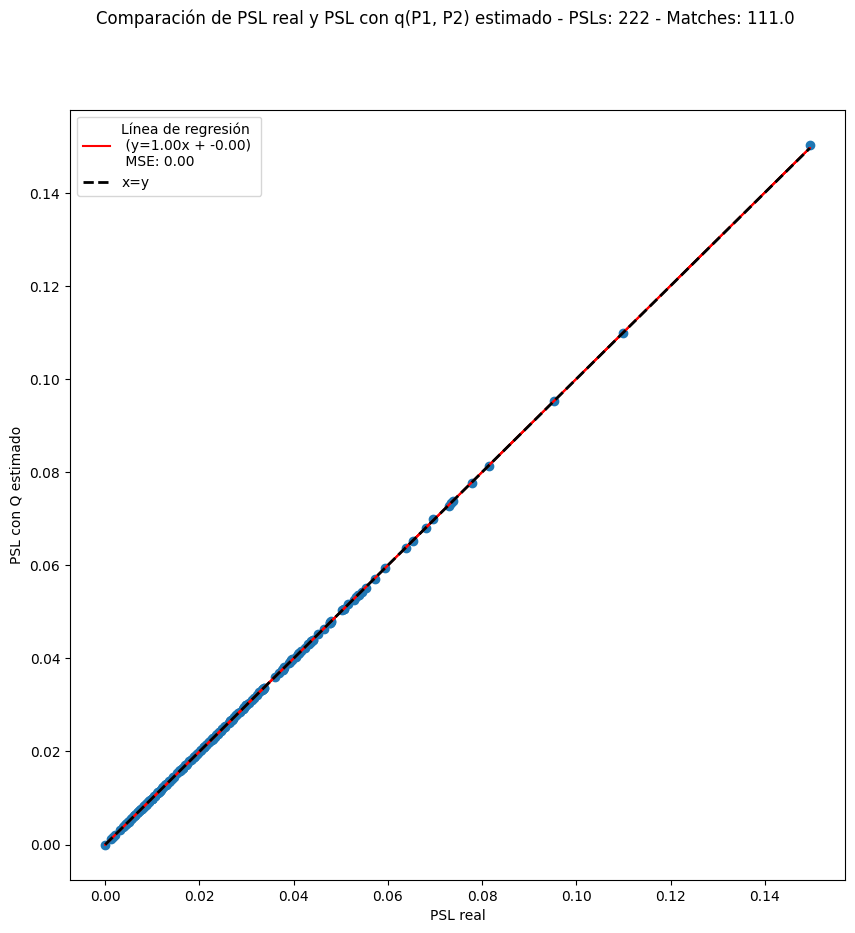

In [348]:

linreg = LinearRegression()

linreg.fit(np.array(X_train.values), np.array(y_train.values))

# Predecir las probabilidades en los datos de prueba
y_pred = linreg.predict(X_test)

sc = linreg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

display(Markdown(f"Score: {sc} - MSE: {mse}"))

evaluate_psl_diffs(
    np.array(
        get_psl_diffs(R_storage, linreg, sample_pairs, matches, player_features_df)
    )
)

<Axes: >

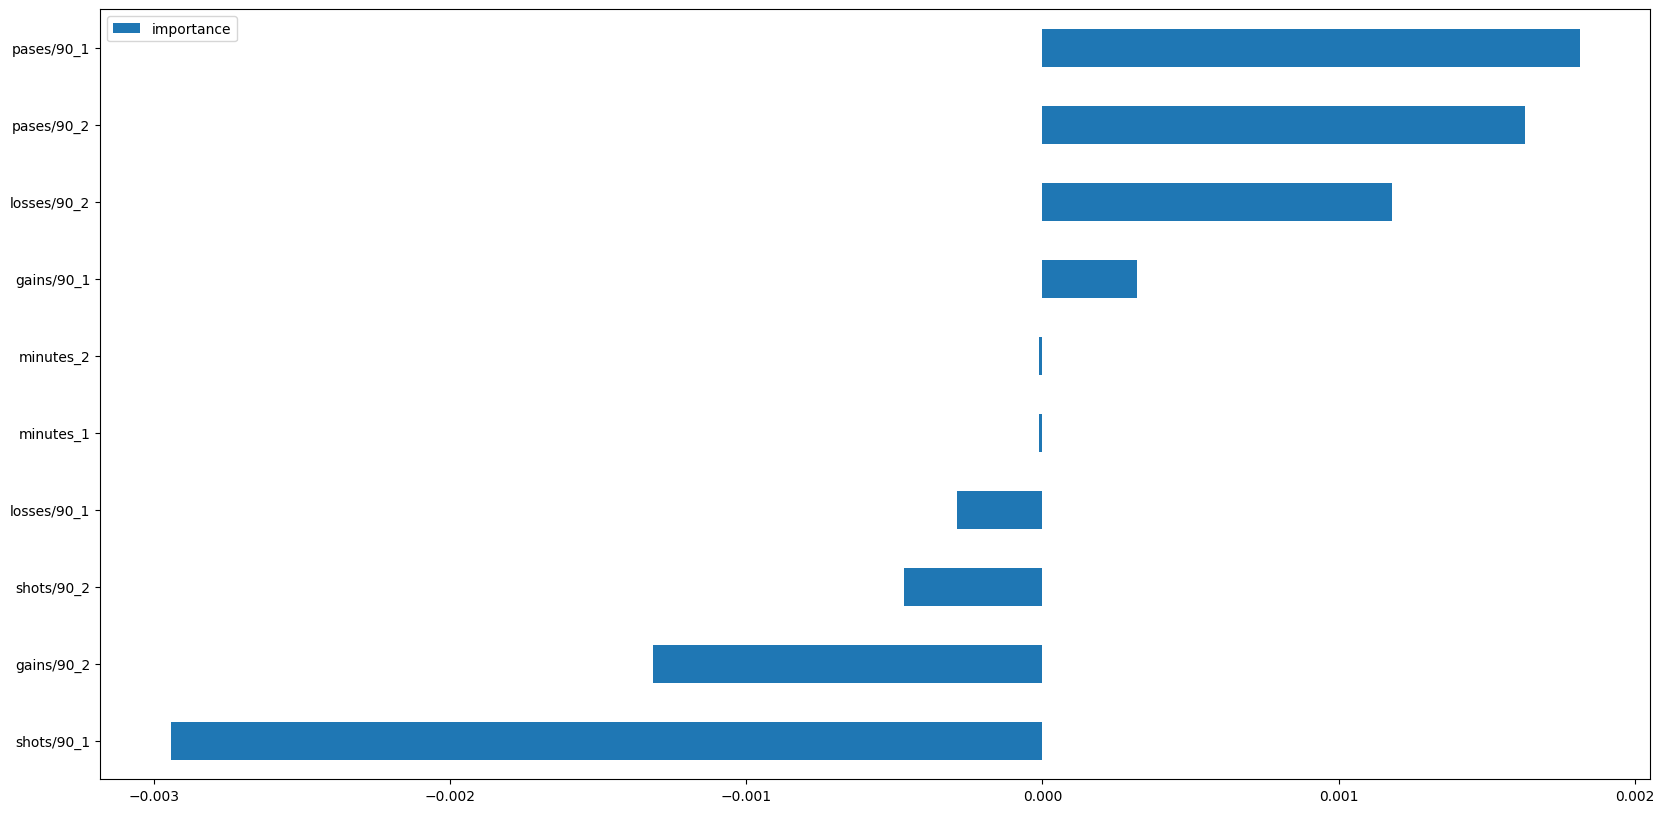

In [351]:
# Feature importance

# Plot linreg betas

importance = pd.DataFrame(linreg.coef_, index=X_train.columns, columns=["importance"])
importance = importance.sort_values(by="importance")

fig, ax = plt.subplots(figsize=(20, 10))

importance.plot(kind="barh", ax=ax)

In [468]:
# Make a Dumb Model

class DumbModel:
    def __init__(self):
        pass

    def fit(self, X, y):
        pass

    def predict(self, X):
        return np.random.rand(X.shape[0])
    
    def score(self, X, y):
        return 0
    

In [ ]:
dumb_model = DumbModel()

evaluate_psl_diffs(
    np.array(
        get_psl_diffs(R_storage, dumb_model, sample_pairs, matches, player_features_df)
    )
)

In [354]:
X_train.columns

Index(['pases/90_1', 'shots/90_1', 'losses/90_1', 'gains/90_1', 'minutes_1',
       'pases/90_2', 'shots/90_2', 'losses/90_2', 'gains/90_2', 'minutes_2'],
      dtype='object')

Score: -0.02001667016752684 - MSE: 0.0053422353189042345

100%|██████████| 111/111 [00:16<00:00,  6.58it/s]


(np.float64(0.9593910329028492),
 np.float64(0.0013512577576633988),
 np.float64(6.471570986502091e-05))

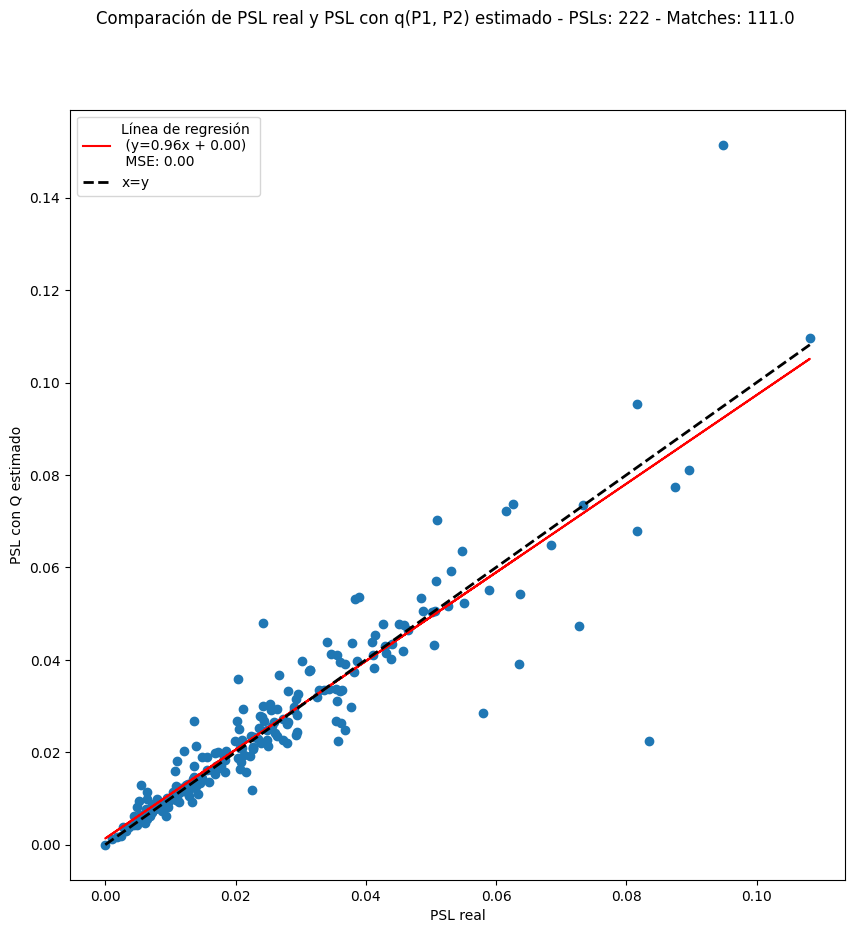

In [360]:
# Linear Regression with less columns, only passes

sub_model_cols = ["pases/90_1", "pases/90_2"]
X_train_passes = X_train[sub_model_cols]

linreg_passes = LinearRegression()

linreg_passes.fit(np.array(X_train_passes.values), np.array(y_train.values))

# Predecir las probabilidades en los datos de prueba
y_pred = linreg_passes.predict(X_test[sub_model_cols])

sc = linreg_passes.score(X_test[sub_model_cols], y_test)
mse = mean_squared_error(y_test, y_pred)

display(Markdown(f"Score: {sc} - MSE: {mse}"))

evaluate_psl_diffs(
    np.array(
        get_psl_diffs(
            R_storage, linreg_passes, sample_pairs, matches, player_features_df, list(set([col[:-2] for col in X_train_passes.columns]))
        )
    )
)

<Axes: >

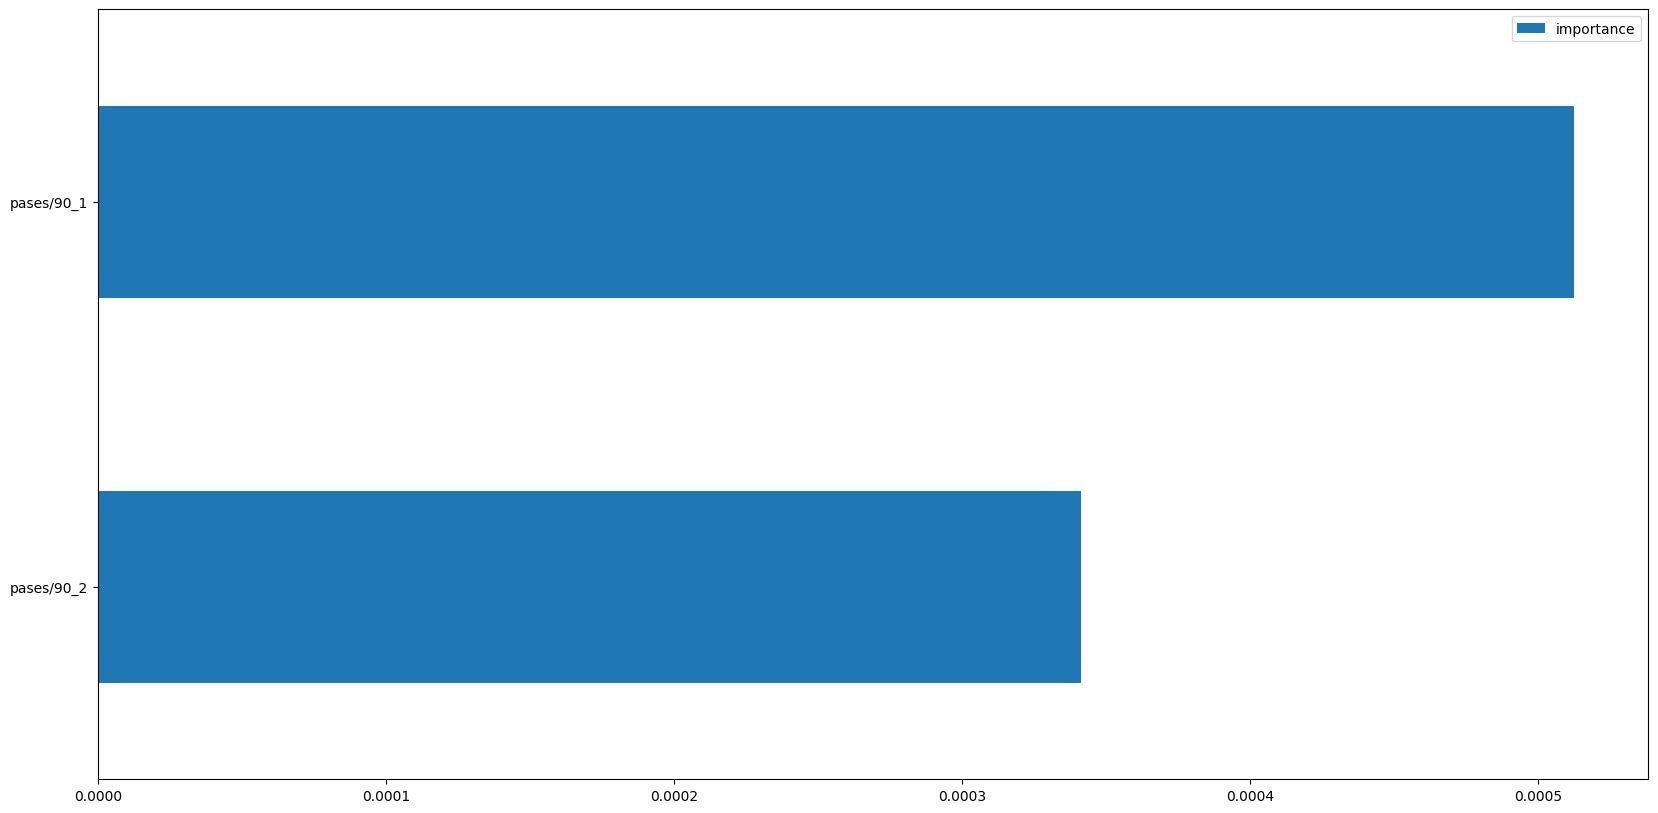

In [362]:
importance = pd.DataFrame(
    linreg_passes.coef_, index=X_train_passes.columns, columns=["importance"]
)
importance = importance.sort_values(by="importance")

fig, ax = plt.subplots(figsize=(20, 10))

importance.plot(kind="barh", ax=ax)

Score: -0.0021877135148349325 - MSE: 0.005248857941146692

100%|██████████| 111/111 [00:16<00:00,  6.86it/s]


UnboundLocalError: local variable 'fig' referenced before assignment

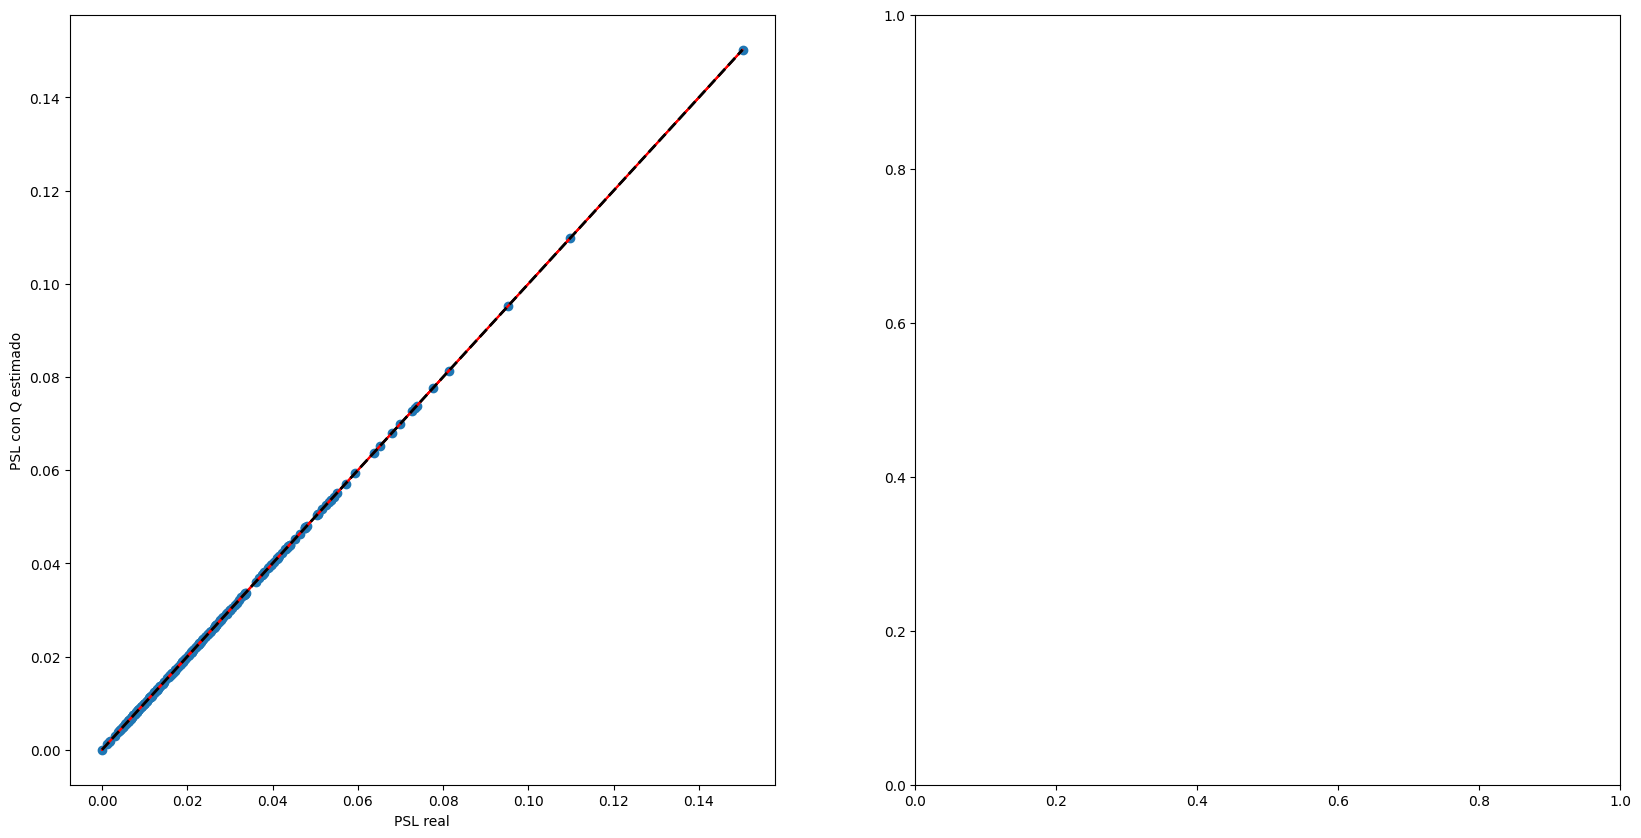

In [367]:
# Withouth passes

sub_model_cols = X_train.columns.difference(["pases/90_1", "pases/90_2"])

X_train_no_passes = X_train[sub_model_cols]

linreg_no_passes = LinearRegression()

linreg_no_passes.fit(np.array(X_train_no_passes.values), np.array(y_train.values))

# Predecir las probabilidades en los datos de prueba
y_pred = linreg_no_passes.predict(X_test[sub_model_cols])
sc = linreg_no_passes.score(X_test[sub_model_cols], y_test)
mse = mean_squared_error(y_test, y_pred)
display(Markdown(f"Score: {sc} - MSE: {mse}"))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

importance = pd.DataFrame(
    linreg_no_passes.coef_, index=X_train_no_passes.columns, columns=["importance"]
).sort_values(by="importance")


evaluate_psl_diffs(
    np.array(
        get_psl_diffs(
            R_storage, linreg_no_passes, sample_pairs, matches, player_features_df, list(set([col[:-2] for col in X_train_no_passes.columns]))
        )
    ),
    ax=axs[0],
)

importance.plot(kind="barh", ax=axs[1])

In [411]:
def train_model(model, X_train, y_train, X_test, y_test, R_storage, sample_pairs, matches, player_features_df, ax=None):
    model.fit(np.array(X_train.values), np.array(y_train.values))

    # Predecir las probabilidades en los datos de prueba
    y_pred = model.predict(X_test)

    sc = model.score(X_test, y_test)
    q_mse = mean_squared_error(y_test, y_pred)

    display(Markdown(f"Score: {sc} - MSE: {q_mse}"))

    return model, y_pred, sc, q_mse

# Train the model with only passes of the player 1

sub_model_cols = ["pases/90_1", "pases/90_2"]
X_train_passes_1 = X_train[sub_model_cols]
X_train_passes_1["pases/90_2"] = 0
linreg_passes_1 = LinearRegression()

def model_info(model, X_train, y_train, X_test, y_test, R_storage, sample_pairs, matches, player_features_df):

    fig, axs = plt.subplots(1, 3, figsize=(20, 10))

    model, y_pred, sc, q_mse = train_model(
        model,
        X_train,
        y_train,
        X_test,
        y_test,
        R_storage,
        sample_pairs,
        matches,
        player_features_df,
    )

    psl_slope, psl_intercept, psl_mse = evaluate_psl_diffs(
        np.array(
            get_psl_diffs(
                R_storage,
                model,
                sample_pairs,
                matches,
                player_features_df,
                list(set([col[:-2] for col in X_train.columns])),
            )
        ),
        ax=axs[1],
    )

    axs[1].legend()

    axs[0].scatter(y_test, y_pred)

    # Regresión lineal para los datos, comparar la pendiente con y=x
    reg = LinearRegression().fit(y_test.values.reshape(-1, 1), y_pred)
    y_pred_line = reg.predict(y_test.values.reshape(-1, 1))

    # Obtener la pendiente (slope) y la intersección (intercept)
    q_slope = reg.coef_[0]
    q_intercept = reg.intercept_

    axs[0].plot(
        y_test, y_pred_line, color="red", label=f"Línea de regresión \n (y={q_slope:.2f}x + {q_intercept:.2f})"
    )

    # Plot y=x for the range of the data
    axs[0].plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], "k--")

    axs[0].set_xlabel("q real")
    axs[0].set_ylabel("q estimada")
    axs[0].set_title("Comparación de q estimada vs q real")

    axs[0].legend()

    if hasattr(model, "coef_"):
        _ = (
            pd.DataFrame(
                model.coef_, index=X_train.columns, columns=["importance"]
            )
            .sort_values(by="importance")
            .plot(kind="barh", ax=axs[2])
        )
    # If model is xgb
    if isinstance(model, xgb.XGBRegressor):
        pd.DataFrame(
            model.feature_importances_, index=X_train.columns, columns=["importance"]
        ).sort_values(by="importance").plot(kind="barh", ax=axs[2])

    axs[2].set_title("Importancia de las variables")

    return model, y_pred, sc, q_mse, psl_slope, psl_intercept, psl_mse

Score: -0.013168339228201598 - MSE: 0.005306367870371653

 15%|█▌        | 17/111 [00:03<00:18,  5.03it/s, no_updates=161, updates=2395]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:17<00:05,  5.00it/s, no_updates=168, updates=12715]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:22<00:00,  4.84it/s, no_updates=168, updates=16794]


(LinearRegression(),
 array([0.0774257 , 0.07016318, 0.09199127, ..., 0.09874078, 0.09827765,
        0.07224359]),
 -0.013168339228201598,
 np.float64(0.005306367870371653),
 np.float64(0.9413437865426398),
 np.float64(-0.0008941839004020721),
 np.float64(0.00580374706947687))

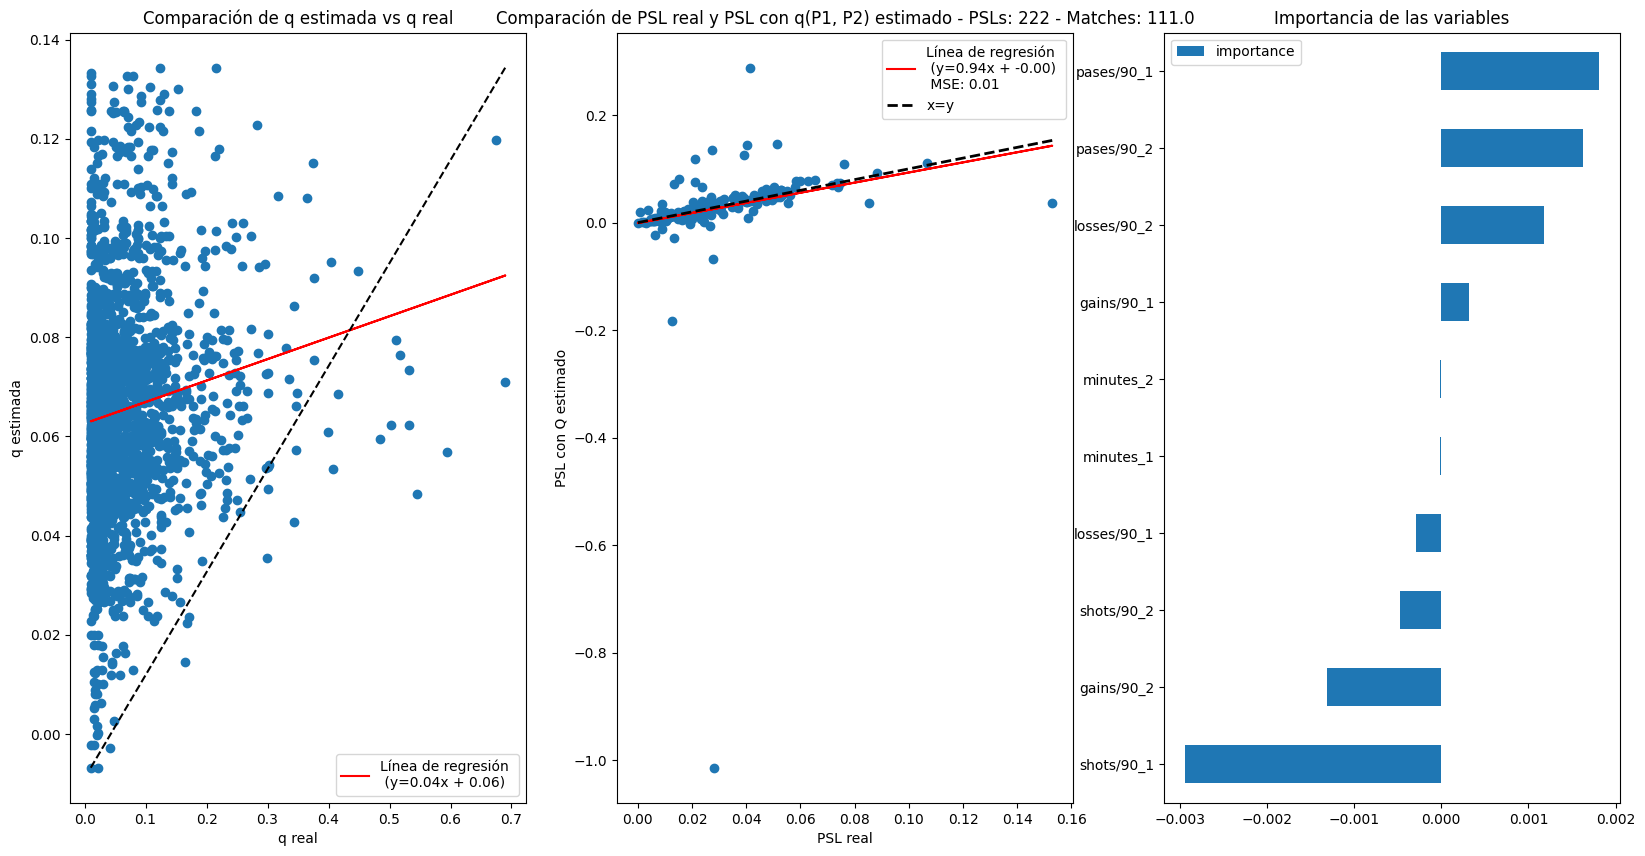

In [463]:
model_info(
    linreg,
    X_train,
    y_train,
    X_test,
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df,
)

Score: 0 - MSE: 0.2744121807480605

 15%|█▌        | 17/111 [00:03<00:16,  5.53it/s, no_updates=0, updates=2556]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:16<00:04,  5.60it/s, no_updates=0, updates=12883]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:21<00:00,  5.18it/s, no_updates=0, updates=16962]


(<__main__.DumbModel at 0x1378f0640>,
 array([0.75119697, 0.51609421, 0.23783377, ..., 0.56670841, 0.27007715,
        0.09567427]),
 0,
 np.float64(0.2744121807480605),
 np.float64(0.8555047782986978),
 np.float64(0.00313371216829382),
 np.float64(8.5797849625223e-05))

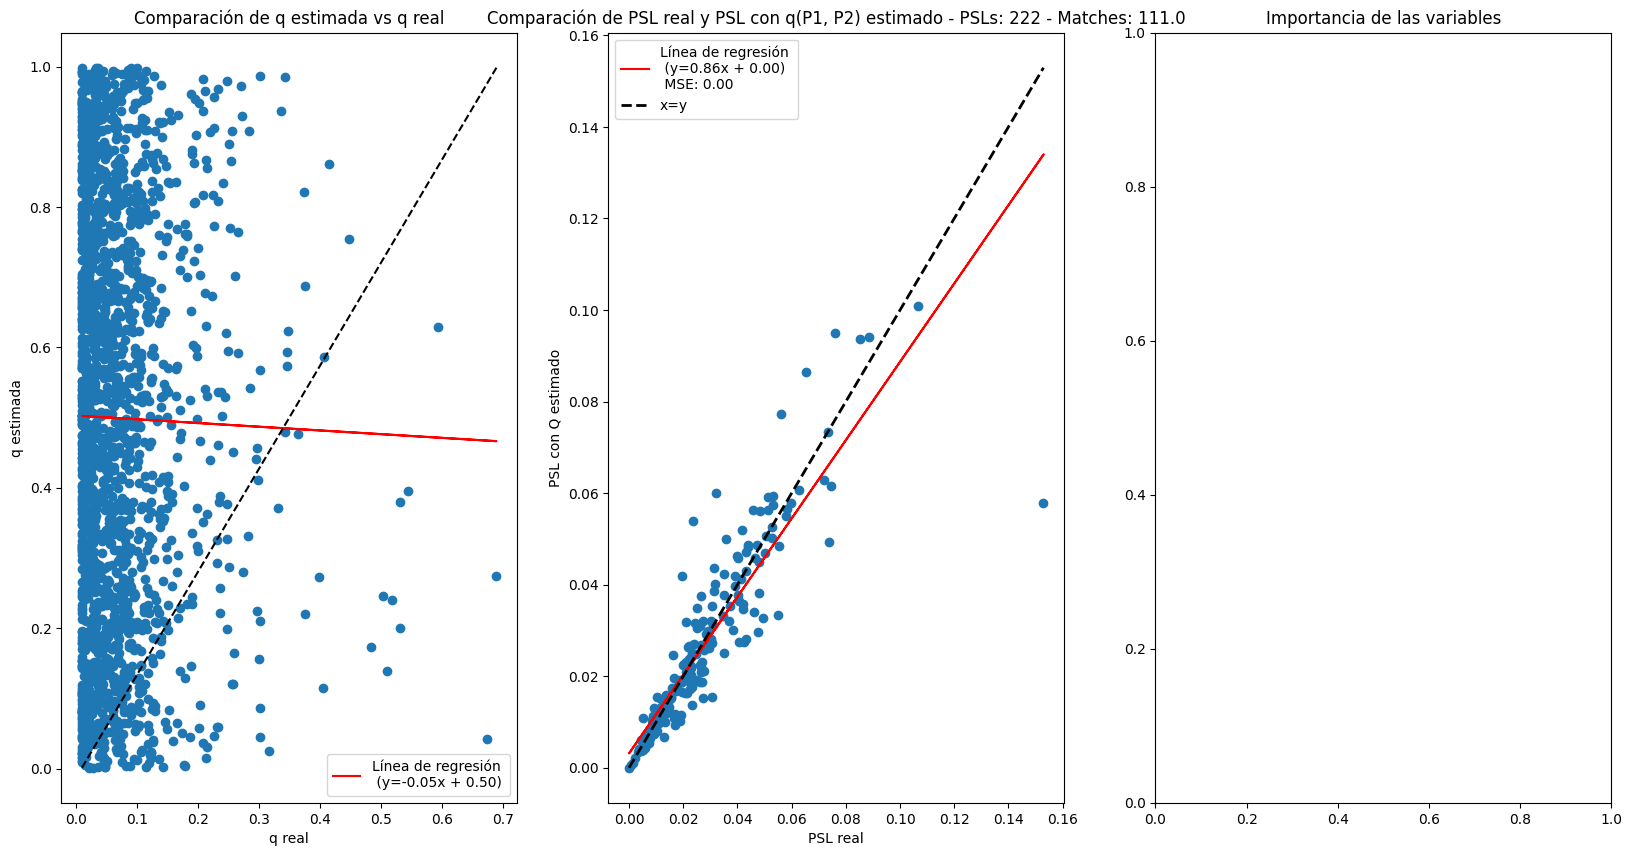

In [469]:
model_info(
    DumbModel(),
    X_train,
    y_train,
    X_test,
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df,
)

Score: -0.009398497534323313 - MSE: 0.005286623701445075

 15%|█▌        | 17/111 [00:03<00:19,  4.75it/s, no_updates=163, updates=2393]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 78%|███████▊  | 87/111 [00:16<00:03,  6.99it/s, no_updates=228, updates=12735]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:22<00:00,  4.92it/s, no_updates=249, updates=16713]


(LinearRegression(),
 array([0.08876775, 0.08876775, 0.08876775, ..., 0.09301547, 0.09301547,
        0.08647987]),
 -0.009398497534323313,
 np.float64(0.005286623701445075),
 np.float64(0.9943748533710977),
 np.float64(5.065549229755703e-05),
 np.float64(5.533149385174306e-06))

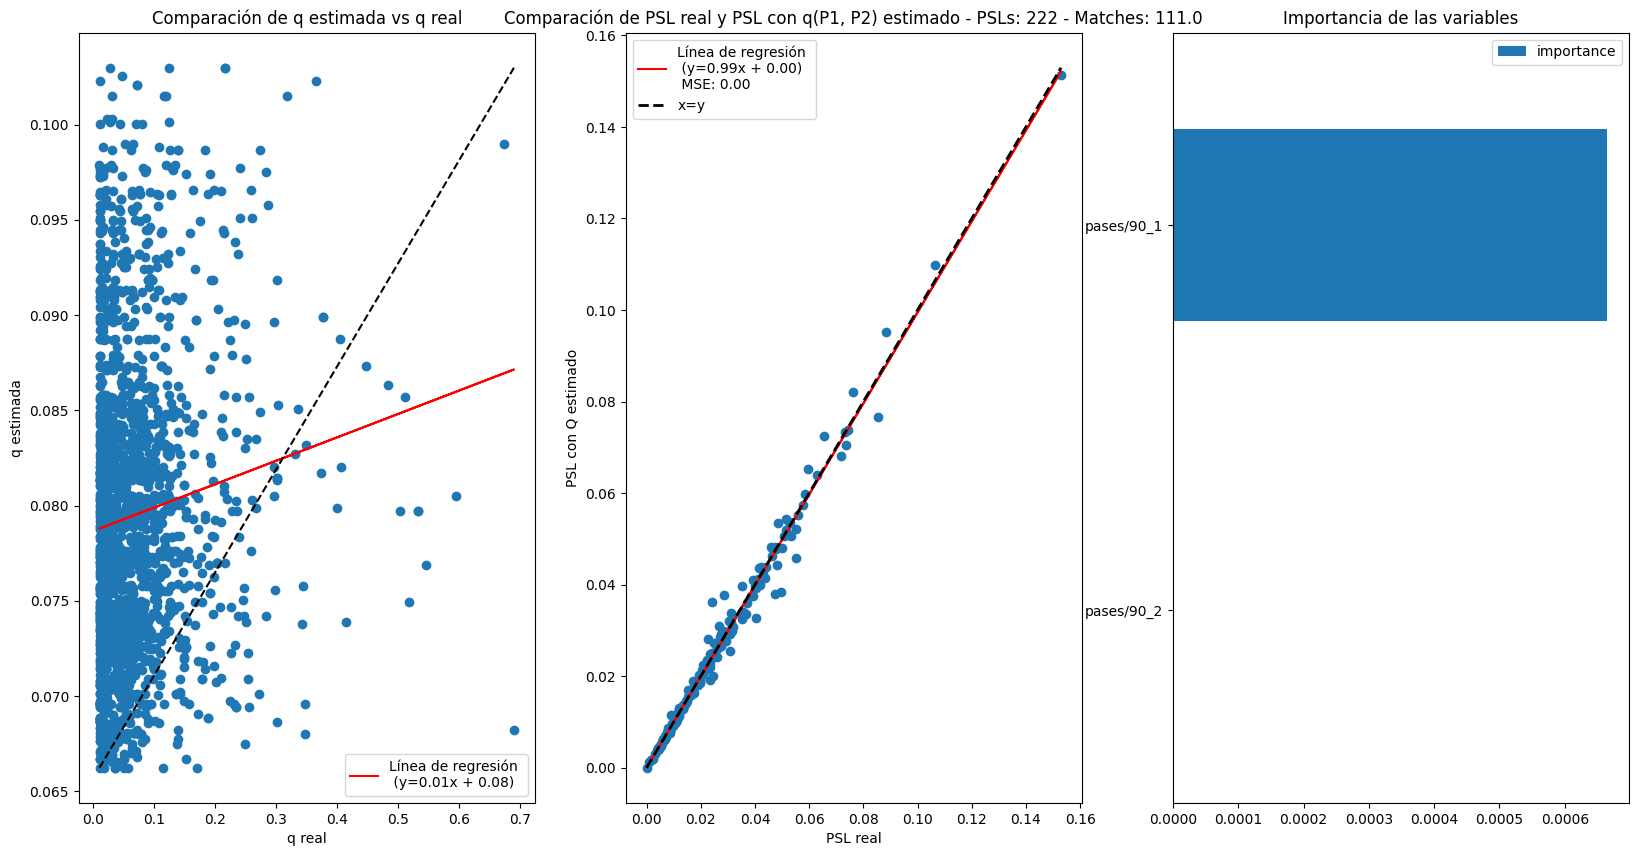

In [470]:
model_info(
    linreg_passes_1,
    X_train_passes_1,
    y_train,
    X_test[X_train_passes_1.columns],
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df,
)

Score: -0.1629834634495786 - MSE: 0.006091009603520992

 14%|█▍        | 16/111 [00:04<00:26,  3.58it/s, no_updates=174, updates=2262]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 85/111 [00:26<00:07,  3.60it/s, no_updates=181, updates=12702]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:33<00:00,  3.29it/s, no_updates=181, updates=16781]


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 array([0.13917348, 0.07690237, 0.04621883, ..., 0.1283325 , 0.13614659,
        0.09847323], dtype=float32),
 -0.1629834634495786,
 np.float64(0.006091009603520992),
 np.float64(0.9604849009022003),
 np.float64(0.0005847267388197387),
 np.f

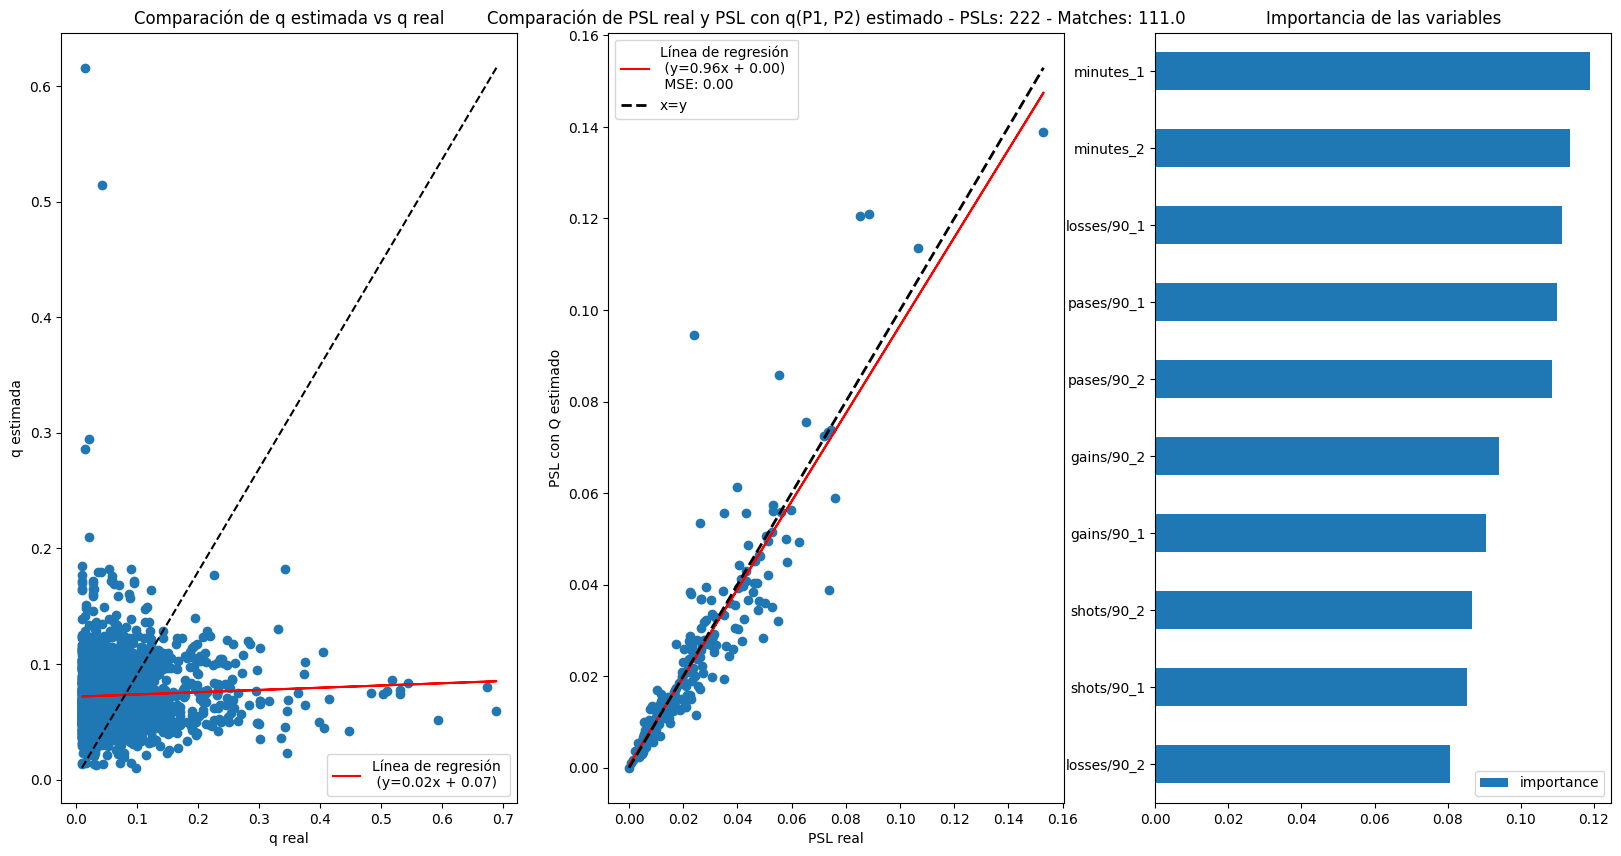

In [471]:
model_info(
    xgb_model,
    X_train,
    y_train,
    X_test,
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df,
)

Score: -0.2145707275972073 - MSE: 0.0063611927413023

 15%|█▌        | 17/111 [00:04<00:24,  3.78it/s, no_updates=161, updates=2275]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 77%|███████▋  | 86/111 [00:23<00:05,  4.38it/s, no_updates=168, updates=12715]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:31<00:00,  3.58it/s, no_updates=168, updates=16794]


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 array([0.08563448, 0.07313304, 0.09738012, ..., 0.09367817, 0.09548327,
        0.10739383], dtype=float32),
 -0.2145707275972073,
 np.float64(0.0063611927413023),
 np.float64(1.0063880182982612),
 np.float64(0.00034243714383410534),
 np.fl

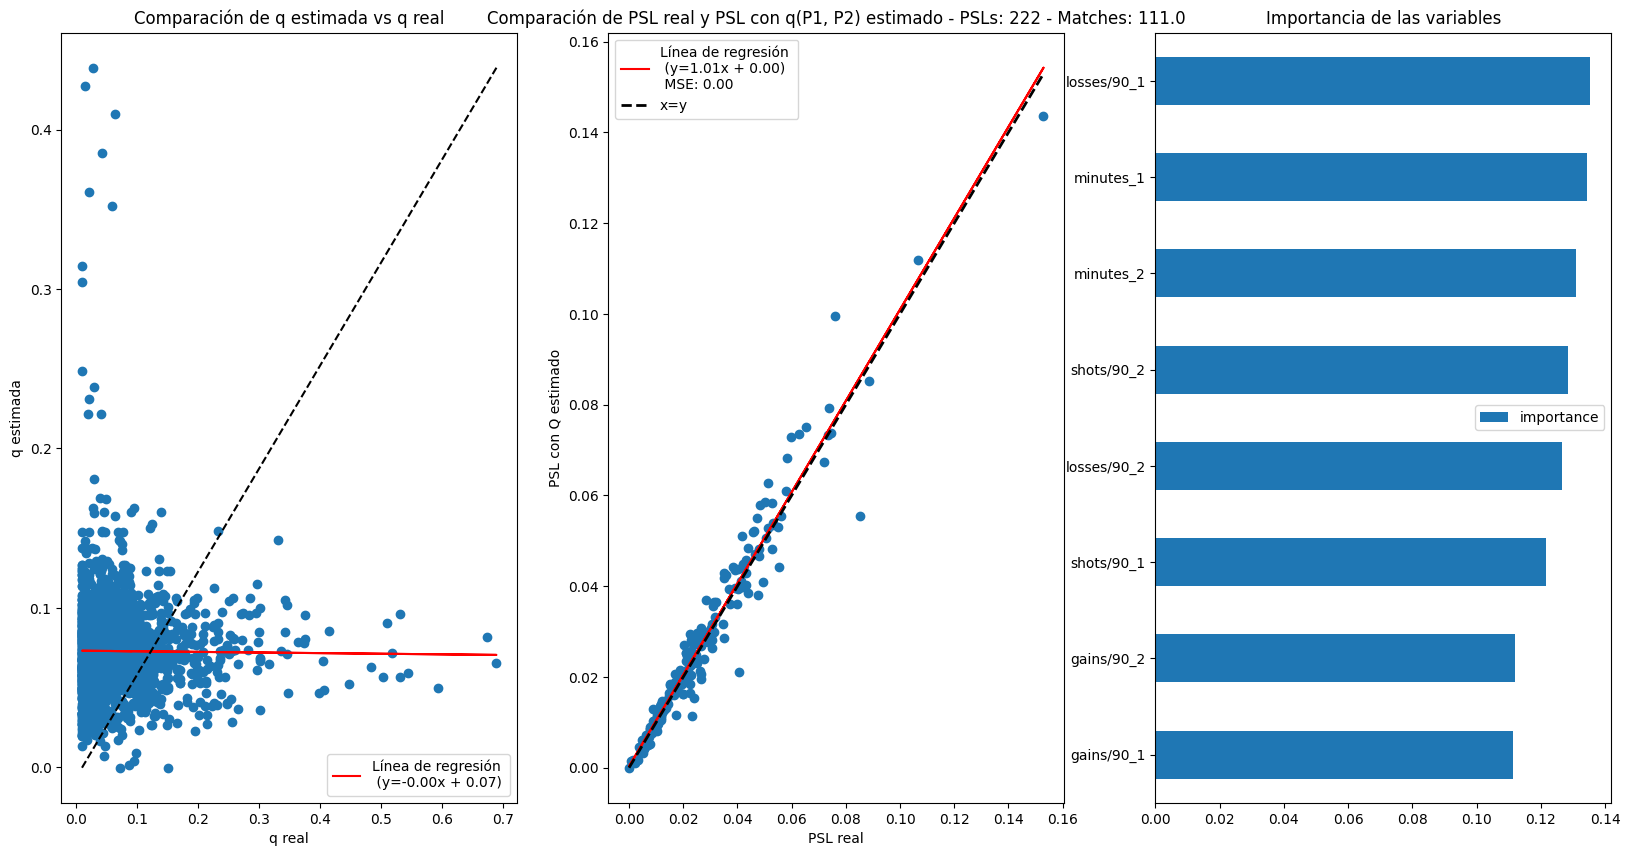

In [472]:
no_passes_cols = X_train.columns.difference(["pases/90_1", "pases/90_2"])
model_info(
    xgb.XGBRegressor(),
    X_train[no_passes_cols],
    y_train,
    X_test[no_passes_cols],
    y_test,
    R_storage,
    sample_pairs,
    matches,
    player_features_df,
)

Score: -0.21471130766909163 - MSE: 0.011587356787326577

100%|██████████| 11/11 [00:03<00:00,  3.36it/s, no_updates=5, updates=1543]


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 array([0.0552441 , 0.07422585, 0.05866591, 0.05853038, 0.06625731,
        0.05978814, 0.0552441 , 0.06124189, 0.10418042, 0.09175336,
        0.14989556, 0.0660946 , 0.07682547, 0.14989556, 0.09175336,
        0.14989556, 0.14989556, 0.062

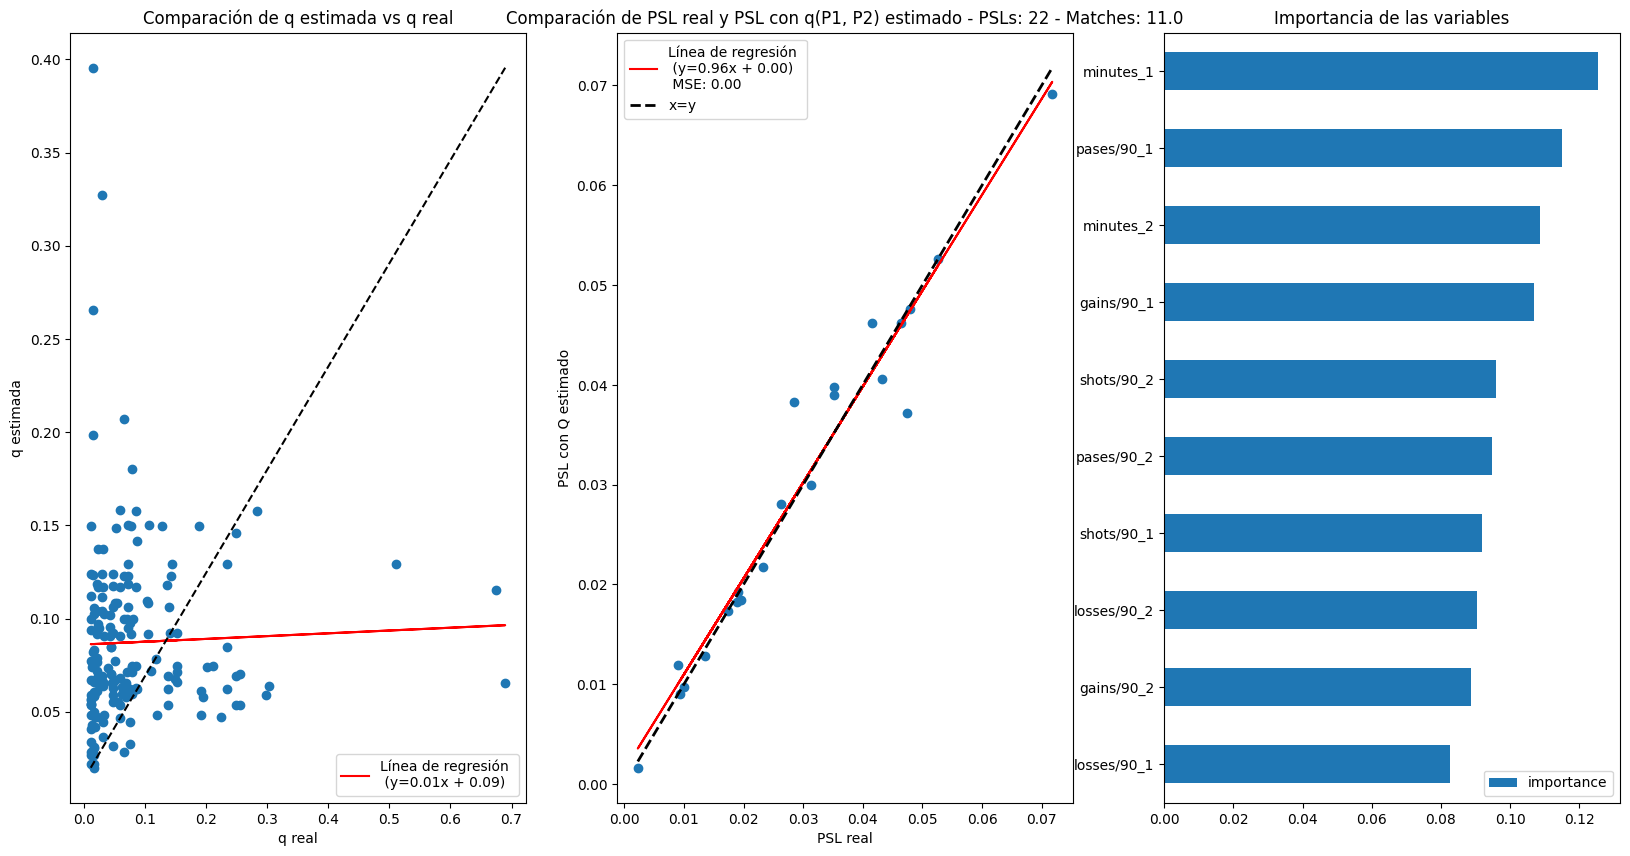

In [474]:
# Remove a whole team from train
# Manchester City
mancity_id = epl[epl["home_team_name"] == "Manchester City"]["home_team_id"].values[0]
mancity_id

mancity_matches_id = epl[
    (epl["home_team_id"] == mancity_id) | (epl["away_team_id"] == mancity_id)
]["match_id"]

X_train_no_mancity = train_left[
    ~train_left["partido_id"].isin(mancity_matches_id)
].drop(columns=["player_1", "player_2", "target", "date", "partido_id"])

y_train_no_mancity = train_left[
    ~train_left["partido_id"].isin(mancity_matches_id)
]["target"]

X_test_only_mancity = test_right[
    test_right["partido_id"].isin(mancity_matches_id)
].drop(columns=["player_1", "player_2", "target", "date", "partido_id"])

y_test_only_mancity = test_right[
    test_right["partido_id"].isin(mancity_matches_id)
]["target"]

mancity_matches = matches[matches["match_id"].isin(mancity_matches_id)]

# sub_R_storage = R_storage[mancity_matches.index]

_ = model_info(
    xgb.XGBRegressor(),
    X_train_no_mancity,
    y_train_no_mancity,
    X_test_only_mancity,
    y_test_only_mancity,
    R_storage,
    sample_pairs,
    mancity_matches,
    player_features_df,
)

Score: -0.14781761136747695 - MSE: 0.0064716259276127

 16%|█▌        | 14/87 [00:04<00:19,  3.77it/s, no_updates=131, updates=1781]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 87/87 [00:24<00:00,  3.55it/s, no_updates=135, updates=12491]


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 array([0.13917348, 0.07690237, 0.04621883, ..., 0.10291585, 0.06438826,
        0.05553801], dtype=float32),
 -0.14781761136747695,
 np.float64(0.0064716259276127),
 np.float64(0.9865945690277268),
 np.float64(0.0002669838623796175),
 np.fl

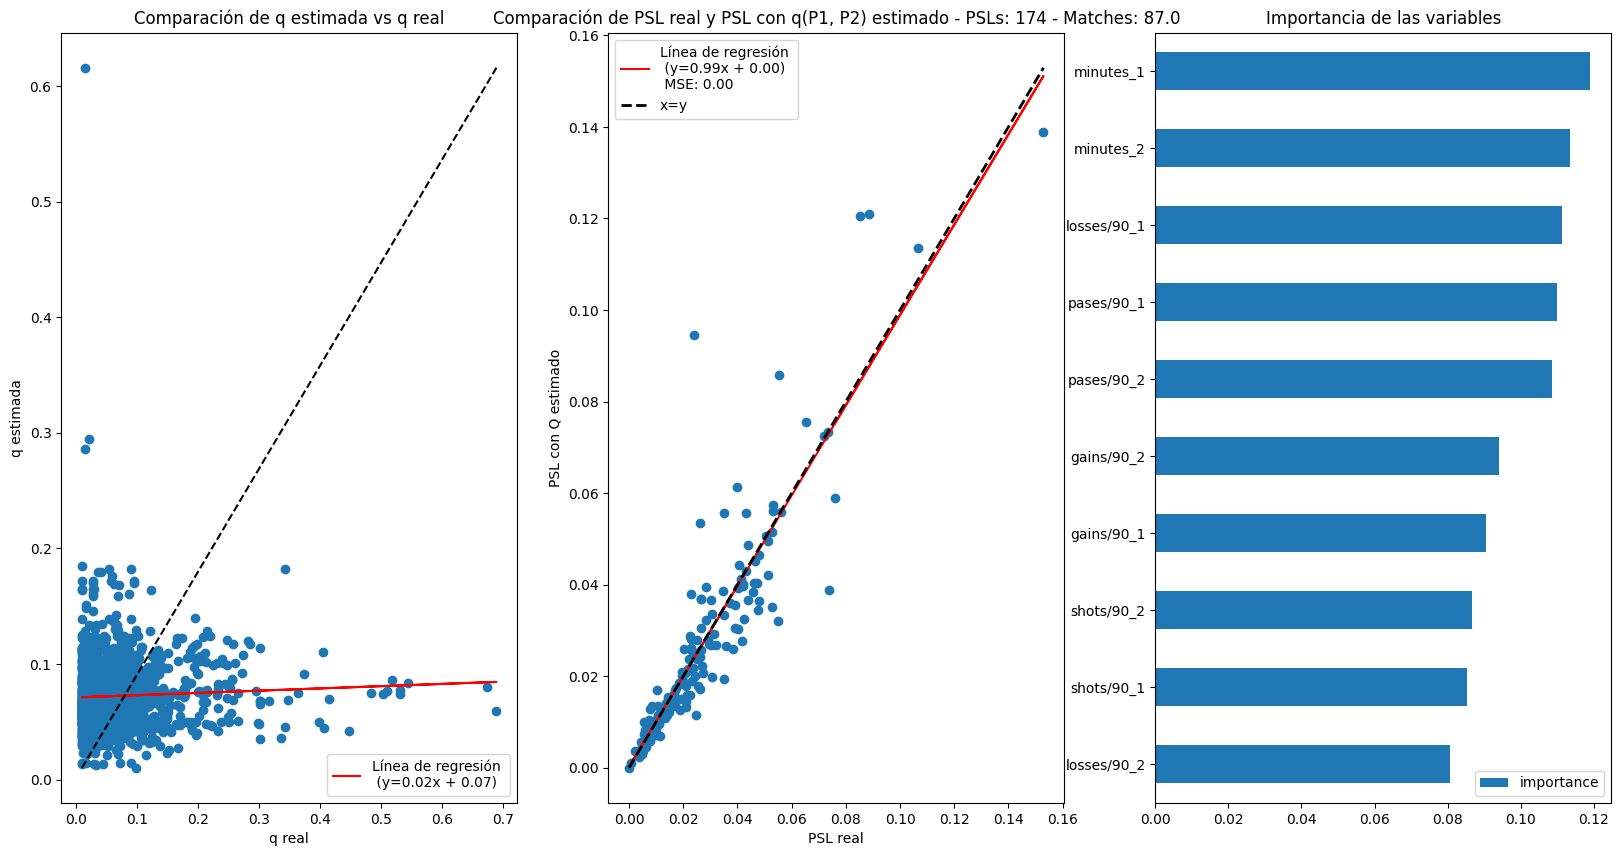

In [480]:
# Remove half of the teams from train

team_ids = epl["home_team_id"].unique()

np.random.seed(42)
np.random.shuffle(team_ids)

half_teams = team_ids[: int(len(team_ids) / 2)]
half_teams_matches = matches[
    matches["home_team_id"].isin(half_teams) | matches["away_team_id"].isin(half_teams)
]

half_teams_matches_id = half_teams_matches["match_id"]

X_train_no_half_teams = train_left[
    ~train_left["partido_id"].isin(half_teams_matches_id)
].drop(columns=["player_1", "player_2", "target", "date", "partido_id"])

y_train_no_half_teams = train_left[
    ~train_left["partido_id"].isin(half_teams_matches_id)
]["target"]

X_test_only_half_teams = test_right[
    test_right["partido_id"].isin(half_teams_matches_id)
].drop(columns=["player_1", "player_2", "target", "date", "partido_id"])

y_test_only_half_teams = test_right[
    test_right["partido_id"].isin(half_teams_matches_id)
]["target"]

model_info(
    xgb.XGBRegressor(),
    X_train_no_half_teams,
    y_train_no_half_teams,
    X_test_only_half_teams,
    y_test_only_half_teams,
    R_storage,
    sample_pairs,
    half_teams_matches,
    player_features_df,
)

Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no se puede invertir.
Singular matrix
Error: La matriz es singular y no 

Text(0.5, 1.0, 'MSE over amount of destruction')

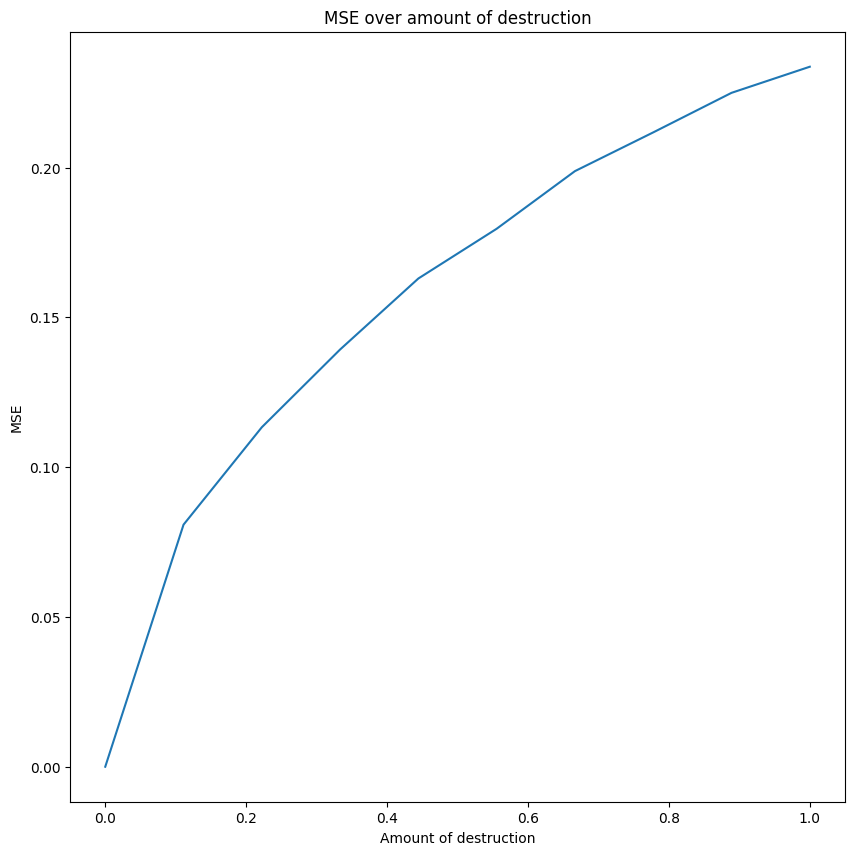

In [489]:
# Gradually destroy the R matrix, compute Q and PSL, and compare with the real PSL, MSE

def destroy_R(R, amount):
    # Destroy the R matrix by setting the amount of values to 0
    # Destroy the values in the diagonal
    # Return the destroyed R matrix

    R = R.copy()
    
    R = (np.random.rand(*R.shape) * amount) + (R * (1 - amount))

    return R

mse_over_amms = []

for amm in np.linspace(0, 1, 10):
    psl_diffs = []

    for i in range(R_storage.shape[0]):
        for j in range(R_storage.shape[1]):
            for k in range(R_storage.shape[2]):
                R = R_storage[i, j, k].copy()[1:, 1:]
                real_psl = psl_estimator(build_Q(R))

                mod_psl = psl_estimator(build_Q(destroy_R(R, amm)))

                psl_diffs.append((real_psl, mod_psl))

    psl_diffs_arr = np.array(psl_diffs)

    slope, intercept, mse = evaluate_psl_diffs(psl_diffs_arr, plot=False)

    mse_over_amms.append((amm, mse))

mse_over_amms = np.array(mse_over_amms)

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(mse_over_amms[:, 0], mse_over_amms[:, 1])

ax.set_xlabel("Amount of destruction")
ax.set_ylabel("MSE")
ax.set_title("MSE over amount of destruction")


## ALS - Alternating Least Squares

In [65]:
data = train_left
data.columns  # Index(['player_1', 'pases/90_1', 'shots/90_1', 'losses/90_1', 'gains/90_1',
#       'minutes_1', 'player_2', 'pases/90_2', 'shots/90_2', 'losses/90_2',
#       'gains/90_2', 'minutes_2', 'partido_id', 'target', 'date'],
#      dtype='object')

# recomendation_matrix is a matrix of:
#   columns of player_1 and player_2
#   rows of player_1 and player_2
#   values are the average target between the two players

players_1 = ds["player_1"].unique()
players_2 = ds["player_2"].unique()

players = np.unique(np.concatenate([players_1, players_2]))


recomendation_matrix = np.zeros((len(players), len(players)))

recomendation_matrix.shape

(521, 521)

In [66]:
for (i, player_1), (j, player_2) in tqdm(
    itertools.product(enumerate(players_1), enumerate(players_2))
):
    mask = (data["player_1"] == player_1) & (data["player_2"] == player_2)
    mask |= (data["player_1"] == player_2) & (data["player_2"] == player_1)
    recomendation_matrix[i, j] = data[mask]["target"].mean()

269880it [02:00, 2244.91it/s]


ValueError: Shape of passed values is (521, 521), indices imply (520, 519)

In [67]:
recomendation_matrix_df = pd.DataFrame(
    recomendation_matrix, index=players, columns=players
)

ratings = recomendation_matrix_df.fillna(0).values
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (interaction / matrix_size)

print("dimension: ", ratings.shape)
print("sparsity: {:.1f}%".format(sparsity))

dimension:  (521, 521)
sparsity: 3.6%


In [68]:
# ALS (Alternating Least Squares)


class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix

    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm

    n_factors : int
        number of latent factors to use in matrix
        factorization model, some machine-learning libraries
        denote this as rank

    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors

    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))

        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record = []
        self.train_mse_record = []
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(
                train, self.user_factors, self.item_factors
            )
            self.item_factors = self._als_step(
                train.T, self.item_factors, self.user_factors
            )
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)

        return self

    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs

    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred

    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse


def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label="Test", linewidth=linewidth)
    plt.plot(model.train_mse_record, label="Train", linewidth=linewidth)
    plt.xlabel("iterations")
    plt.ylabel("MSE")
    plt.legend(loc="best")

In [69]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        non_zero_indices = np.flatnonzero(ratings[user])
        if len(non_zero_indices) < 10:
            test_index = np.random.choice(
                non_zero_indices, size=len(non_zero_indices), replace=False
            )
        else:
            test_index = np.random.choice(non_zero_indices, size=10, replace=False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]

    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test


# Ejemplo de uso
train_rating, test_rating = create_train_test(ratings)

train_rating.shape, test_rating.shape

((521, 521), (521, 521))

In [70]:
# There are players in the test set that are not in the train set
# Add them to the train set with 0 rating
missing_players = set(recomendation_matrix_df.columns) - set(recomendation_matrix_df.index)

for player in missing_players:
    recomendation_matrix_df[player] = 0

recomendation_matrix_df = recomendation_matrix_df.fillna(0)
ratings = recomendation_matrix_df.values

train_rating, test_rating = create_train_test(ratings)
train_rating.shape, test_rating.shape

((521, 521), (521, 521))

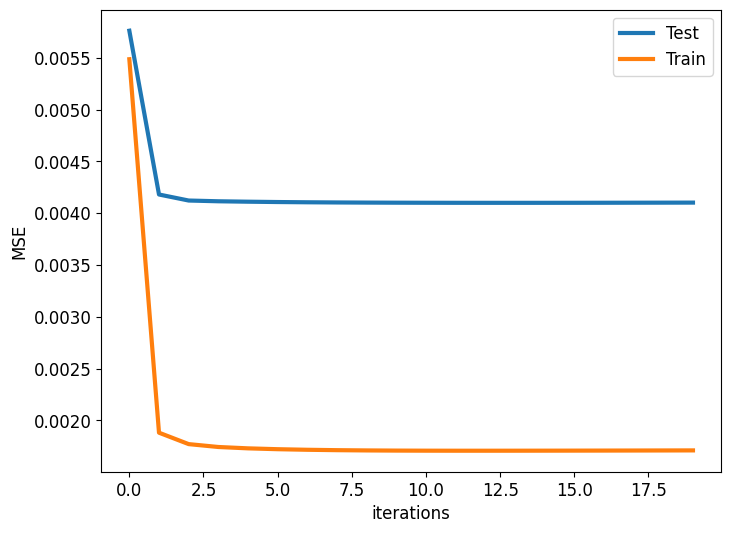

In [71]:
als = ExplicitMF(n_iters=20, n_factors=40, reg=0.01)
als.fit(train_rating, test_rating)
plot_learning_curve(als)

In [72]:
als_pred = als.predict()

als_pred_df = pd.DataFrame(als_pred, index=recomendation_matrix_df.index, columns=recomendation_matrix_df.columns)
als_pred_df

,3.0,160.0,363.0,1131.0,1195.0,1212.0,1216.0,1243.0,1256.0,1344.0,...,110403.0,111565.0,112516.0,114312.0,115556.0,125510.0,126184.0,132931.0,133798.0,148418.0
3.0,0.009603,0.013968,0.047061,0.015305,0.037621,0.018461,0.021456,-0.000094,0.007437,0.002138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160.0,0.045392,0.026161,0.062734,0.069421,0.056786,0.068919,0.059242,0.100667,0.072099,0.050983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363.0,0.029894,0.015251,0.013713,0.042059,0.030391,0.044649,0.023233,0.068622,0.043585,0.032705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1131.0,0.038329,0.018048,0.019222,0.055213,0.034776,0.056503,0.033553,0.092942,0.059562,0.044647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1195.0,0.024310,0.034244,0.100585,0.036183,0.091123,0.046361,0.043368,0.000784,0.015826,0.004533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125510.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126184.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132931.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133798.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
def replace_q_values_als(
    R_df,
    als_pred,
    p1,
    p2,
):
    # Given a 14x14 R matrix, replace the q values for p1, p2 with the model predictions
    # Get the features for p1 and p2 from the features_df
    # Get the model predictions for p1, p2
    # Replace the values in the R matrix
    # Return the updated R matrix

    q_1_2 = als_pred.loc[p1, p2]
    q_2_1 = als_pred.loc[p2, p1]

    R_df.loc[p1, p2] = q_1_2
    R_df.loc[p2, p1] = q_2_1

    return R_df, q_1_2, q_2_1


match_id_RS_index_map = {
    m: i
    for i, m in enumerate(
        [partido["match_id"].values[0] for partido in separar_partidos(epl)]
    )
}


def match_id_2_RS_index(match_id):
    return match_id_RS_index_map[match_id]


def get_psl_diffs_als(
    R_storage,
    als_pred,
    sample_pairs,
    matches,
):
    psls_diffs = []
    partidos = separar_partidos(matches)
    # pi_overhead = 380 - len(partidos)
    no_updates = 0
    updates = 0

    iterator = tqdm(partidos)
    for pi, partido in enumerate(iterator):
        try:
            match_id = partido["match_id"].values[0]
        except:
            continue

        for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
            team_psls = []
            team_alt_psls = []

            lineups = separar_partido_del_equipo_en_lineups(equipo)
            lineup_durations = np.array(
                [get_lineup_duration(lineup) for lineup in lineups]
            )

            for li, lineup in enumerate(lineups):
                jugadores = get_jugadores(lineup)
                team_rs_index = match_id_2_RS_index(match_id)
                R_f_s = R_storage[team_rs_index, ti, li].copy()
                # print("R from Storage:", R_f_s.shape)
                R_df = R_to_DataFrame(R_f_s, R_f_s[0, 2:13])
                # print("R DF:", R_df.shape)

                R = R_f_s[1:, 1:]
                # print("R 14x14: ", R.shape)
                real_psl = psl_estimator(build_Q(R))
                team_psls.append(real_psl)

                R_mod = R.copy()

                # Check jugadores are in R_df [0, 2:13]
                if not all([jugador in R_df.columns for jugador in jugadores]):
                    # print(pi + pi_overhead, ti, li, jugadores)
                    # print(lineup_durations[li])
                    # visualize_R_matrix(R_f_s)
                    team_alt_psls.append(0)
                    continue

                for i, player in enumerate(jugadores):
                    if player in sample_pairs["player_1"].values:
                        for j, player2 in enumerate(jugadores):
                            if player2 != player:
                                # tmp = R_df.loc[player, player2]
                                tmp_R = R[i + 1, j + 1]
                                R_df, q_1_2, q_2_1 = replace_q_values_als(
                                    R_df, als_pred, player, player2
                                )
                                R_mod[i + 1, j + 1] = q_1_2
                                R_mod[j + 1, i + 1] = q_2_1
                                # post = R_df.loc[player, player2]
                                post_R = R_mod[i + 1, j + 1]
                                # if tmp == post:
                                # raise ValueError("No update")

                                if tmp_R == post_R:
                                    no_updates += 1
                                else:
                                    updates += 1
                                    # print(no_updates)
                                    # raise ValueError("No update")

                # R = np.array(R_df.values)
                # print(R.shape)
                modified_psl = psl_estimator(build_Q(R_mod))
                if real_psl == modified_psl:
                    iterator.set_postfix(
                        {
                            "no_updates": no_updates,
                            "updates": updates,
                        }
                    )

                    # raise ValueError("No update")
                team_alt_psls.append(modified_psl)

            psl = np.average(team_psls, weights=lineup_durations)
            psl_alt = np.average(team_alt_psls, weights=lineup_durations)
            psls_diffs.append((psl, psl_alt))

    return psls_diffs

In [74]:
matches = epl[epl["date"] >= date_2_3]

 19%|█▉        | 21/111 [00:00<00:01, 45.24it/s, no_updates=499, updates=2741]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 79%|███████▉  | 88/111 [00:02<00:00, 43.17it/s, no_updates=1801, updates=10140]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:02<00:00, 44.75it/s, no_updates=2242, updates=12281]


(np.float64(0.9847264283056574),
 np.float64(-0.0008677778927390009),
 np.float64(1.0809177106547568e-05))

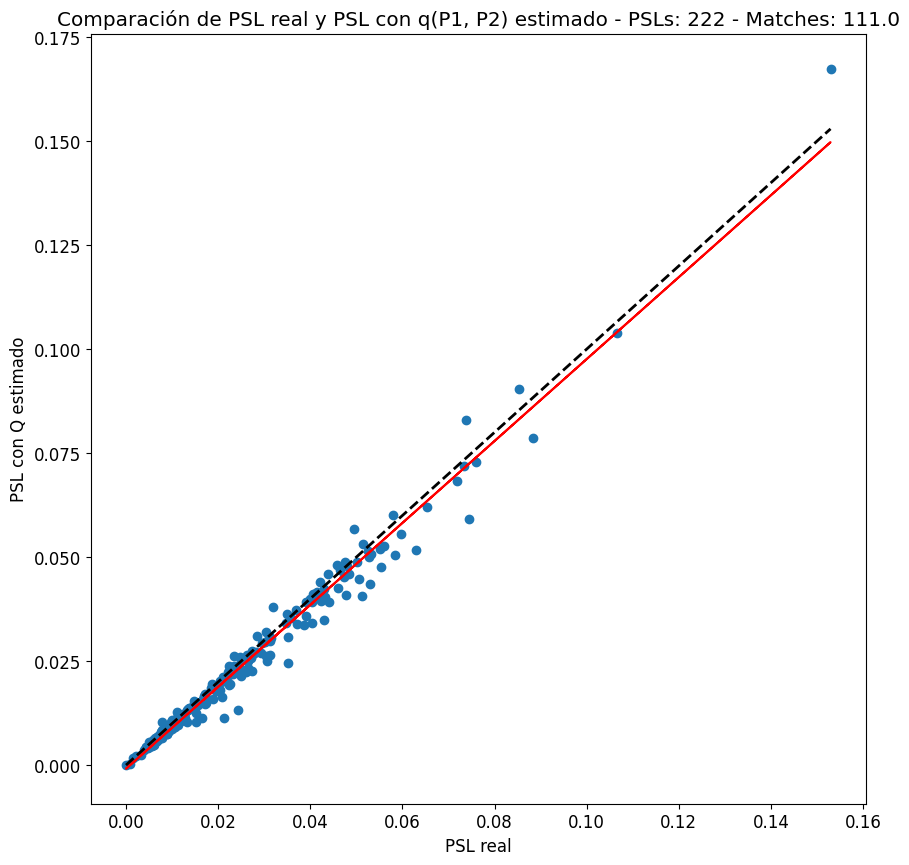

In [75]:
evaluate_psl_diffs(np.array(get_psl_diffs_als(R_storage, als_pred_df, sample_pairs, matches)))

In [86]:
y_test = test_right["target"]
preds = []

for _, row in test_right.iterrows():
    player_1 = row["player_1"]
    player_2 = row["player_2"]

    pred = als_pred_df.loc[player_1, player_2]
    preds.append(pred)

y_pred = np.array(preds)

y_test.shape, y_pred.shape


((1362,), (1362,))

In [88]:
from IPython.display import display, Markdown

 19%|█▉        | 21/111 [00:00<00:02, 40.69it/s, no_updates=496, updates=2676]

Error: La matriz es singular y no se puede invertir.
Singular matrix


 83%|████████▎ | 92/111 [00:02<00:00, 43.29it/s, no_updates=1801, updates=10140]

Error: La matriz es singular y no se puede invertir.
Singular matrix


100%|██████████| 111/111 [00:02<00:00, 41.28it/s, no_updates=2242, updates=12281]
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_90404/2199082731.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


Score: 0.0006267360748236639 - MSE: 0.009890119439863837

PSL Slope: 0.9847264283056574 - PSL Intercept: -0.0008677778927390009 - PSL MSE: 1.0809177106547568e-05

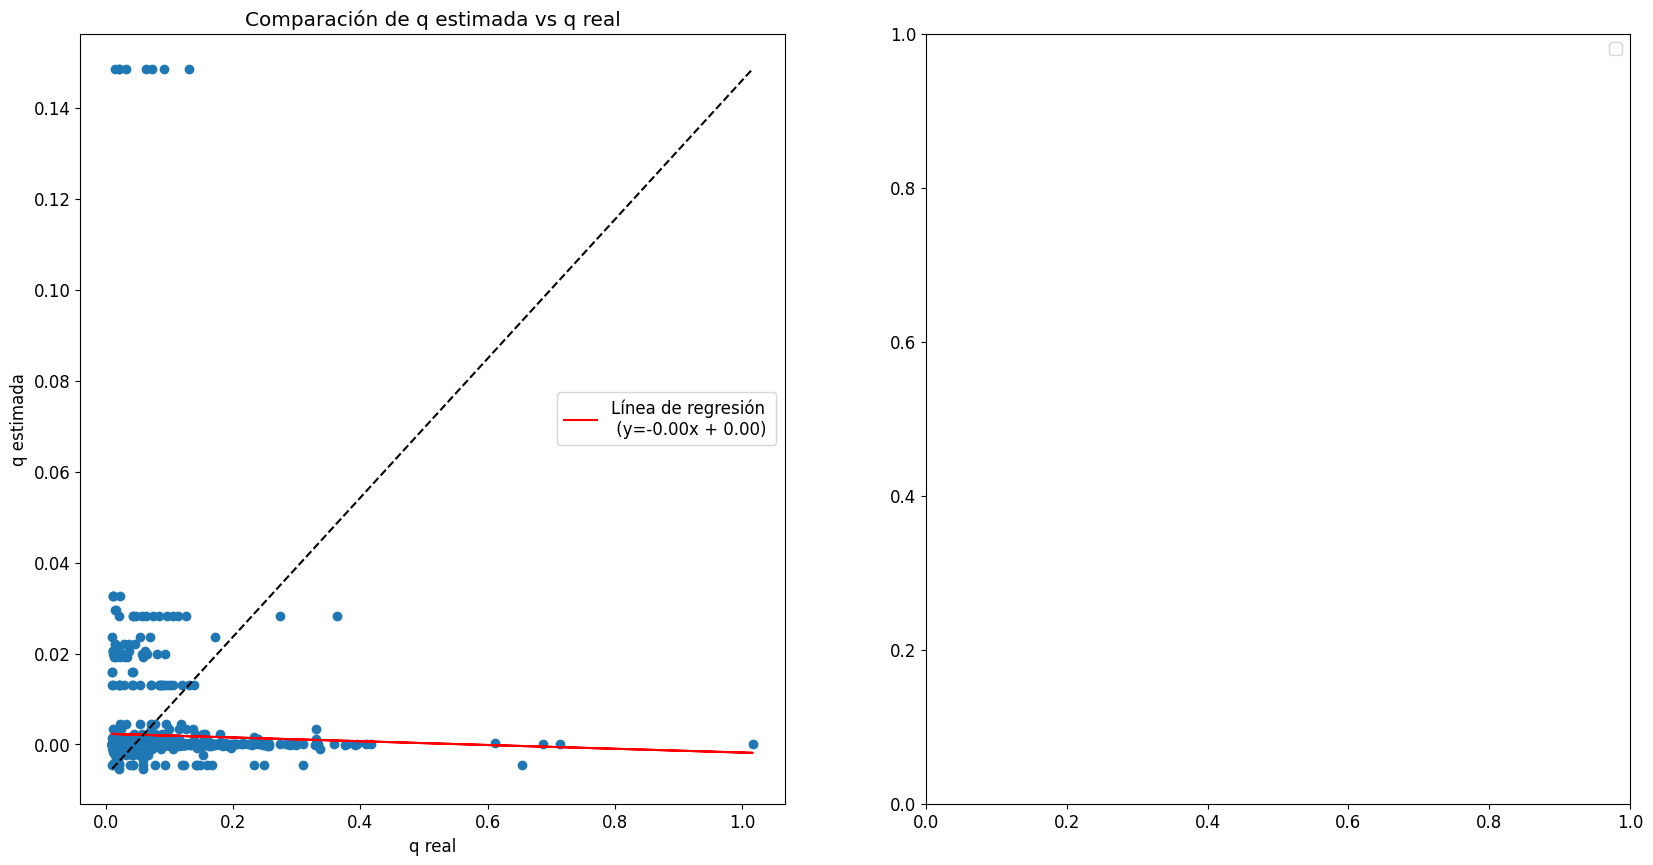

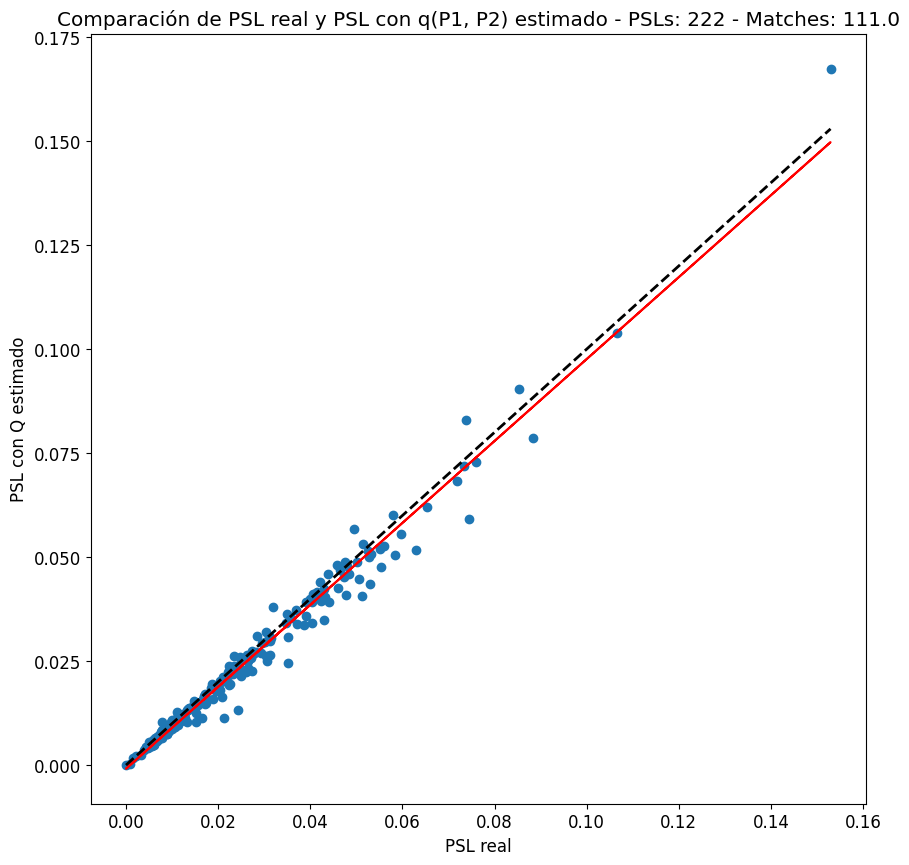

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

psl_slope, psl_intercept, psl_mse = evaluate_psl_diffs(
    np.array(get_psl_diffs_als(R_storage, als_pred_df, sample_pairs, matches))
)

axs[1].legend()

axs[0].scatter(y_test, y_pred)

# Regresión lineal para los datos, comparar la pendiente con y=x
reg = LinearRegression().fit(y_test.values.reshape(-1, 1), y_pred)
y_pred_line = reg.predict(y_test.values.reshape(-1, 1))

# Obtener la pendiente (slope) y la intersección (intercept)
q_slope = reg.coef_[0]
q_intercept = reg.intercept_

axs[0].plot(
    y_test,
    y_pred_line,
    color="red",
    label=f"Línea de regresión \n (y={q_slope:.2f}x + {q_intercept:.2f})",
)

# Plot y=x for the range of the data
axs[0].plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], "k--")

axs[0].set_xlabel("q real")
axs[0].set_ylabel("q estimada")
axs[0].set_title("Comparación de q estimada vs q real")

axs[0].legend()

sc = reg.score(y_test.values.reshape(-1, 1), y_pred)
mse = mean_squared_error(y_test, y_pred)

display(Markdown(f"Score: {sc} - MSE: {mse}"))
display(Markdown(f"PSL Slope: {psl_slope} - PSL Intercept: {psl_intercept} - PSL MSE: {psl_mse}"))